In [1]:
from community import community_louvain
from dataloader import DataLoader
import math
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
import umap.umap_ as umap
import warnings

warnings.filterwarnings("ignore")


C:\Users\sandr\UntrackedFolder\NetworkScienceProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loader = DataLoader(hs_code=282520)

_initialize_data took 24.9808 seconds


In [3]:
polar_df = loader.get_data()
df = polar_df.to_pandas()

In [4]:
years = sorted(df['t'].unique())
yearly_graphs = loader.get_yearly_graphs(years)

In [5]:
###################################################
# Parameters
###################################################
start_year = 2005
end_year = 2022
window_size = 3
epochs = 50
lr = 0.01
embedding_dim = 32
hidden_dim = 64

In [6]:
# DEVICE
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

###################################################
# Load and Filter Data
###################################################
years_of_interest = [y for y in years if start_year <= y <= end_year]

if len(years_of_interest) < 2:
    raise ValueError("Not enough years of data for temporal analysis.")

all_countries = np.union1d(df['export_country'].unique(), df['import_country'].unique())
country_to_id = {c: i for i, c in enumerate(all_countries)}
num_nodes = len(all_countries)

Using device: cpu


In [7]:
###################################################
# Node Feature Builder
###################################################
def build_node_features_for_year(year_data, all_countries):
    # If GDP features not available, use zero features
    if 'gdpcap_o' not in year_data.columns or 'gdpcap_d' not in year_data.columns:
        node_features = np.zeros((len(all_countries), 2))
        return torch.tensor(node_features, dtype=torch.float)

    export_gdp = year_data.groupby("export_country")["gdpcap_d"].mean().to_dict()
    import_gdp = year_data.groupby("import_country")["gdpcap_o"].mean().to_dict()

    node_features = []
    for c in all_countries:
        gdp_o_val = import_gdp.get(c, 0.0)
        gdp_d_val = export_gdp.get(c, 0.0)
        node_features.append([gdp_o_val, gdp_d_val])
    return torch.tensor(node_features, dtype=torch.float)

In [8]:
###################################################
# Graph Snapshots for each Year
###################################################
edge_feature_cols = ["v"]
scaler = StandardScaler()
all_edge_attrs = df[edge_feature_cols].fillna(0.0)
scaler.fit(all_edge_attrs)

def build_graph_for_year(year):
    year_df = df[df['t'] == year]
    if year_df.empty:
        return Data(x=torch.zeros((num_nodes,2)), edge_index=torch.empty((2,0), dtype=torch.long))

    x = build_node_features_for_year(year_df, all_countries)
    src = year_df['export_country'].map(country_to_id)
    dst = year_df['import_country'].map(country_to_id)
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)

    attrs = year_df[edge_feature_cols].fillna(0.0).values
    attrs = scaler.transform(attrs)
    edge_attr = torch.tensor(attrs, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

year_graphs = []
for y in years_of_interest:
    data_y = build_graph_for_year(y)
    year_graphs.append((y, data_y))

In [9]:
###################################################
# GCN Encoder
###################################################
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [10]:
###################################################
# Training for Yearly Embeddings
###################################################
year_embeddings = {}

for y, data_y in year_graphs:
    data_y = data_y.to(device)
    encoder = GCNEncoder(in_channels=data_y.x.size(1),
                         hidden_channels=hidden_dim,
                         out_channels=embedding_dim)
    model = GAE(encoder=encoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    rev_edge_index = torch.stack([data_y.edge_index[1], data_y.edge_index[0]], dim=0)
    full_edge_index = torch.cat([data_y.edge_index, rev_edge_index], dim=1)
    data_y.edge_index = full_edge_index

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model.encode(data_y.x, data_y.edge_index)
        loss = model.recon_loss(z, data_y.edge_index)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        z = model.encode(data_y.x, data_y.edge_index)
    year_embeddings[y] = z.cpu().numpy()

In [11]:
###################################################
# Sliding Window Analysis of Network Structure
###################################################
def build_nx_graph_from_edges(edge_index):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for j in range(edge_index.size(1)):
        u = edge_index[0, j].item()
        v = edge_index[1, j].item()
        G.add_edge(u, v)
    return G

window_metrics = []
for i in range(len(years_of_interest) - window_size + 1):
    window_years = years_of_interest[i:i+window_size]
    combined_edge_index = []
    for wy in window_years:
        idx = years_of_interest.index(wy)
        ei = year_graphs[idx][1].edge_index
        combined_edge_index.append(ei)
    combined_edge_index = torch.cat(combined_edge_index, dim=1)

    combined_edge_index = torch.unique(combined_edge_index, dim=1)

    G_window = build_nx_graph_from_edges(combined_edge_index)

    deg_centrality = nx.degree_centrality(G_window)
    bet_centrality = nx.betweenness_centrality(G_window)
    communities = nx.algorithms.community.greedy_modularity_communities(G_window)
    num_communities = len(communities)

    window_metrics.append({
        'start_year': window_years[0],
        'end_year': window_years[-1],
        'avg_degree_centrality': np.mean(list(deg_centrality.values())),
        'avg_betweenness_centrality': np.mean(list(bet_centrality.values())),
        'num_communities': num_communities
    })

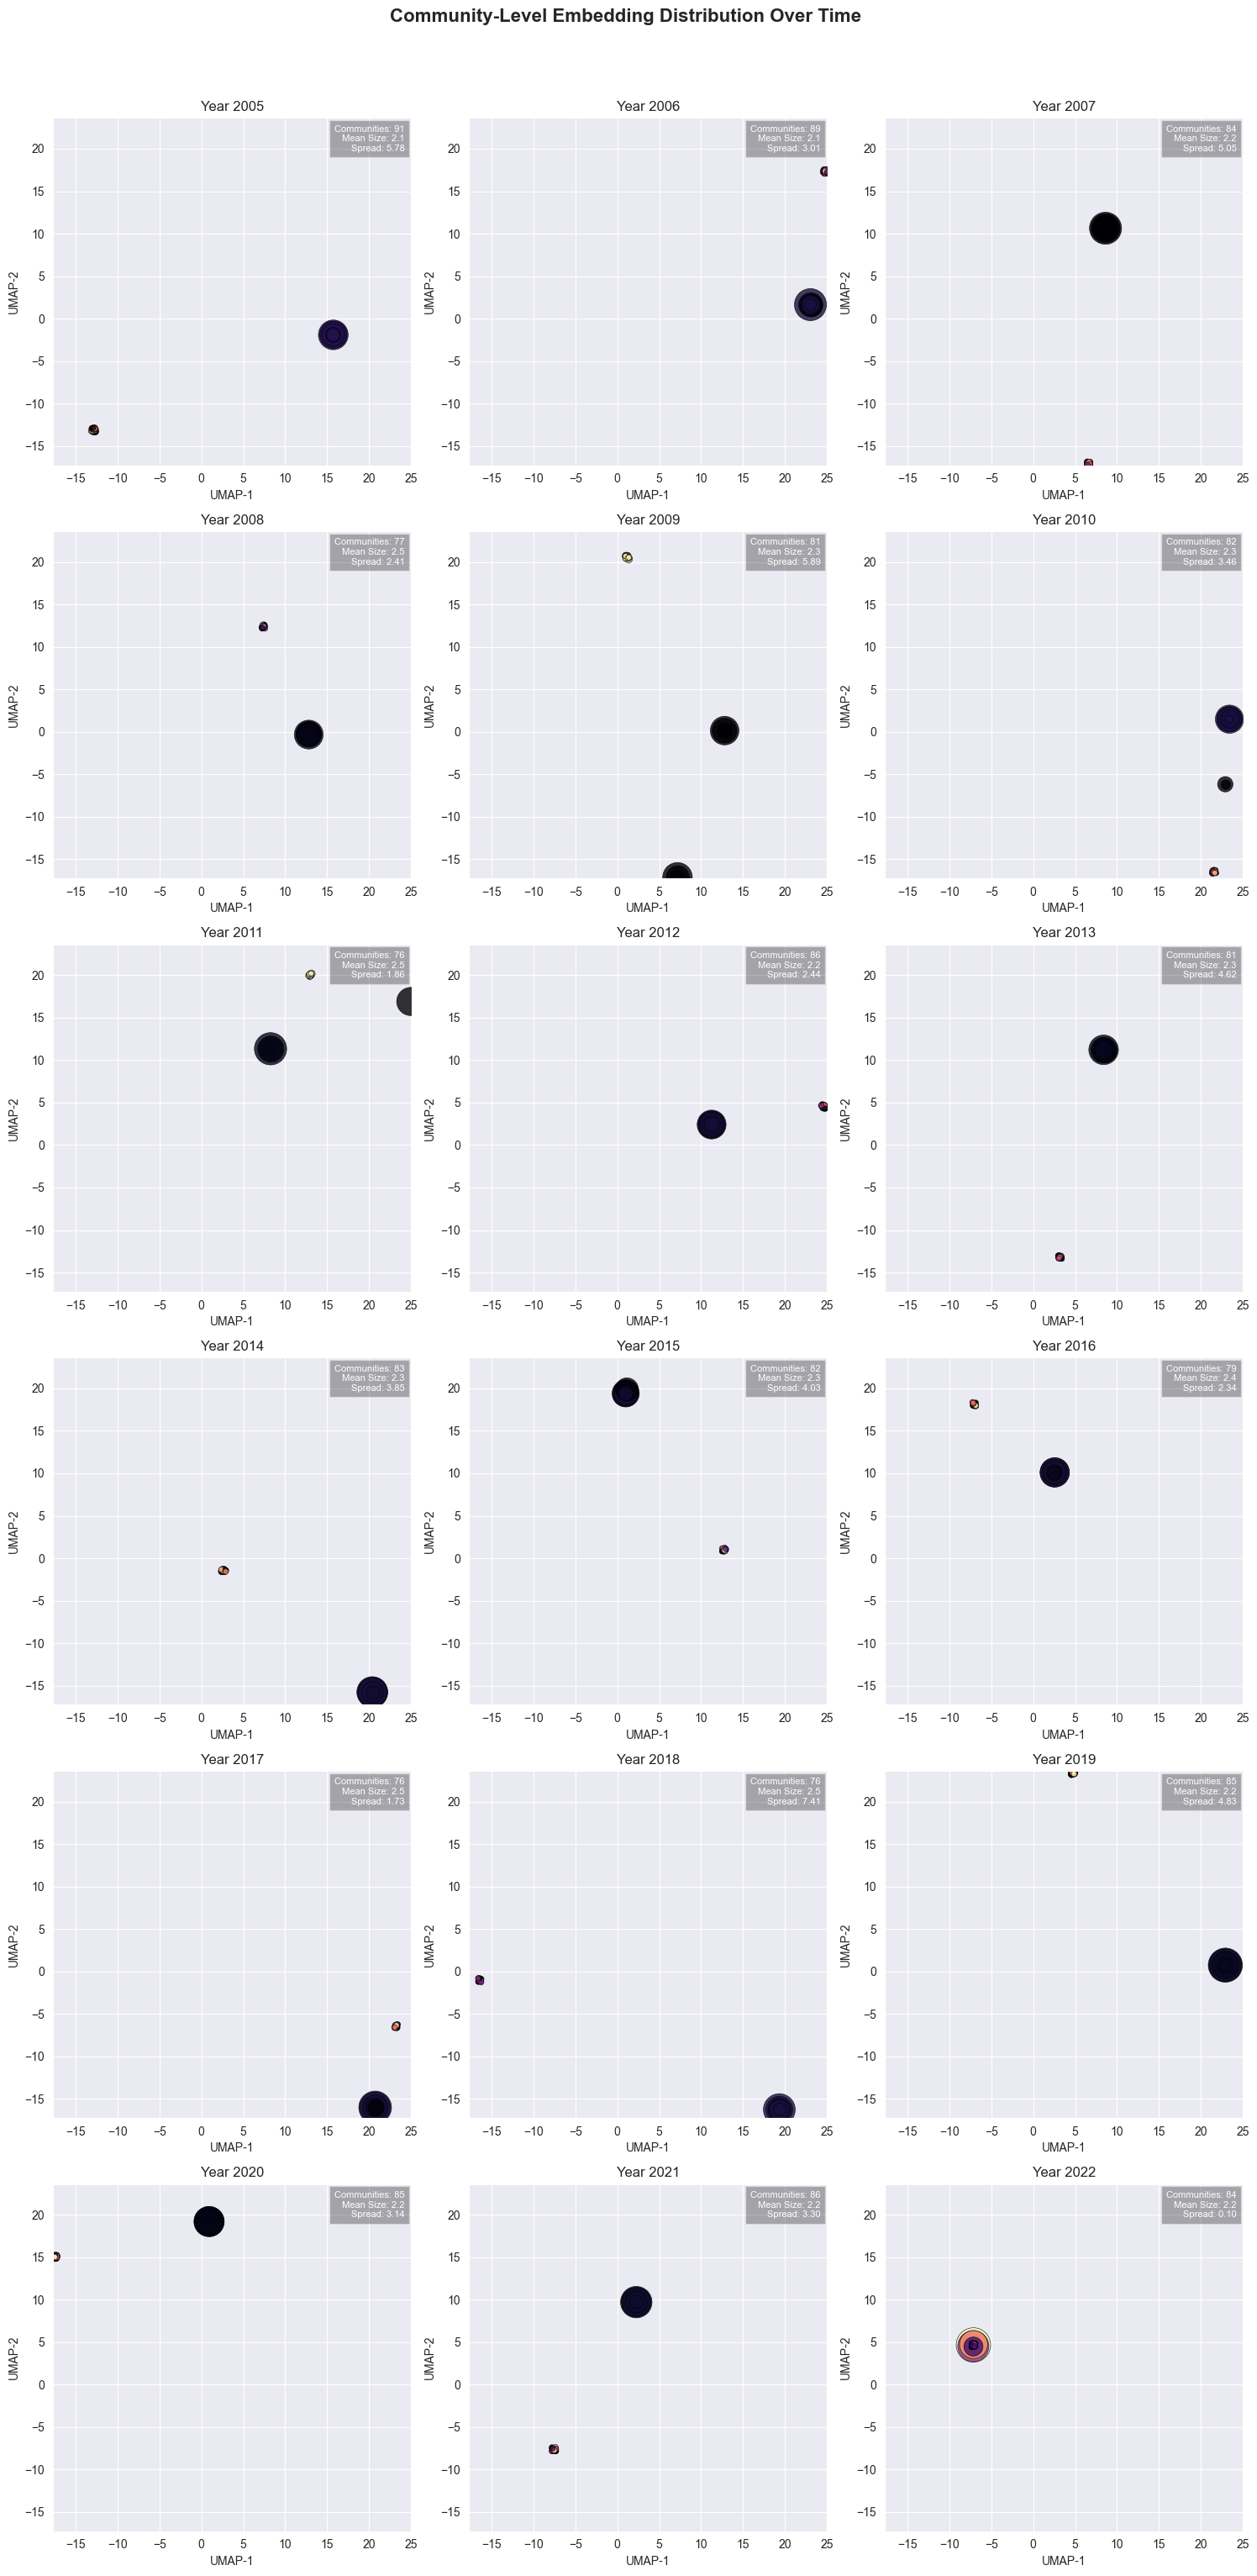

In [12]:


num_nodes = len(all_countries)
embedding_dim = list(year_embeddings.values())[0].shape[1]

###################################################
# 1. Community Aggregation by Year
###################################################
def get_communities_for_year(data_y):
    G_y = nx.Graph()
    G_y.add_nodes_from(range(num_nodes))
    for j in range(data_y.edge_index.size(1)):
        u = data_y.edge_index[0, j].item()
        v = data_y.edge_index[1, j].item()
        G_y.add_edge(u, v)
    communities = nx.algorithms.community.greedy_modularity_communities(G_y)
    return communities

year_communities = {}
for y, data_y in year_graphs:
    year_communities[y] = get_communities_for_year(data_y)

###################################################
# Community-Level Embeddings
###################################################
year_comm_embeddings = {}
year_comm_sizes = {}
for y in years_of_interest:
    emb = year_embeddings[y]
    comms = year_communities[y]

    comm_embs = []
    comm_sizes = []
    for cset in comms:
        c_indices = list(cset)
        c_emb = emb[c_indices].mean(axis=0)
        comm_embs.append(c_emb)
        comm_sizes.append(len(c_indices))
    comm_embs = np.array(comm_embs)
    year_comm_embeddings[y] = comm_embs
    year_comm_sizes[y] = np.array(comm_sizes)

all_comm_embeddings = []
comm_labels = []
for y in years_of_interest:
    cemb = year_comm_embeddings[y]
    for i in range(cemb.shape[0]):
        all_comm_embeddings.append(cemb[i])
        comm_labels.append((y, i))

all_comm_embeddings = np.vstack(all_comm_embeddings)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
all_comm_2d = reducer.fit_transform(all_comm_embeddings)

x_min, x_max = all_comm_2d[:,0].min(), all_comm_2d[:,0].max()
y_min, y_max = all_comm_2d[:,1].min(), all_comm_2d[:,1].max()

cols = 3
rows = math.ceil(len(years_of_interest)/cols)
fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axs = axs.flatten()

###################################################
# Plot Years Arranged in a Grid
###################################################
for idx, y in enumerate(years_of_interest):
    year_indices = [i for i, (yr, _) in enumerate(comm_labels) if yr == y]
    year_embs_2d = all_comm_2d[year_indices]
    x = year_embs_2d[:,0]
    yy = year_embs_2d[:,1]

    xy = np.vstack([x, yy])
    z = gaussian_kde(xy)(xy)

    comm_sizes = year_comm_sizes[y]
    size_scaled = 50 * (comm_sizes / comm_sizes.mean())

    ax = axs[idx]
    sc = ax.scatter(x, yy, c=z, cmap='magma', s=size_scaled, alpha=0.8, edgecolors='black', linewidths=0.5)
    ax.set_title(f"Year {y}", fontsize=12)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

    n_comms = len(comm_sizes)
    mean_size = comm_sizes.mean()
    spread = np.sqrt((x.var() + yy.var())/2.0)

    summary_text = (f"Communities: {n_comms}\n"
                    f"Mean Size: {mean_size:.1f}\n"
                    f"Spread: {spread:.2f}")
    ax.text(0.98, 0.98, summary_text, transform=ax.transAxes,
            va='top', ha='right', fontsize=8,
            bbox=dict(facecolor='black', alpha=0.3, pad=4),
            color='white')

for i in range(len(years_of_interest), len(axs)):
    fig.delaxes(axs[i])

fig.suptitle("Community-Level Embedding Distribution Over Time", fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


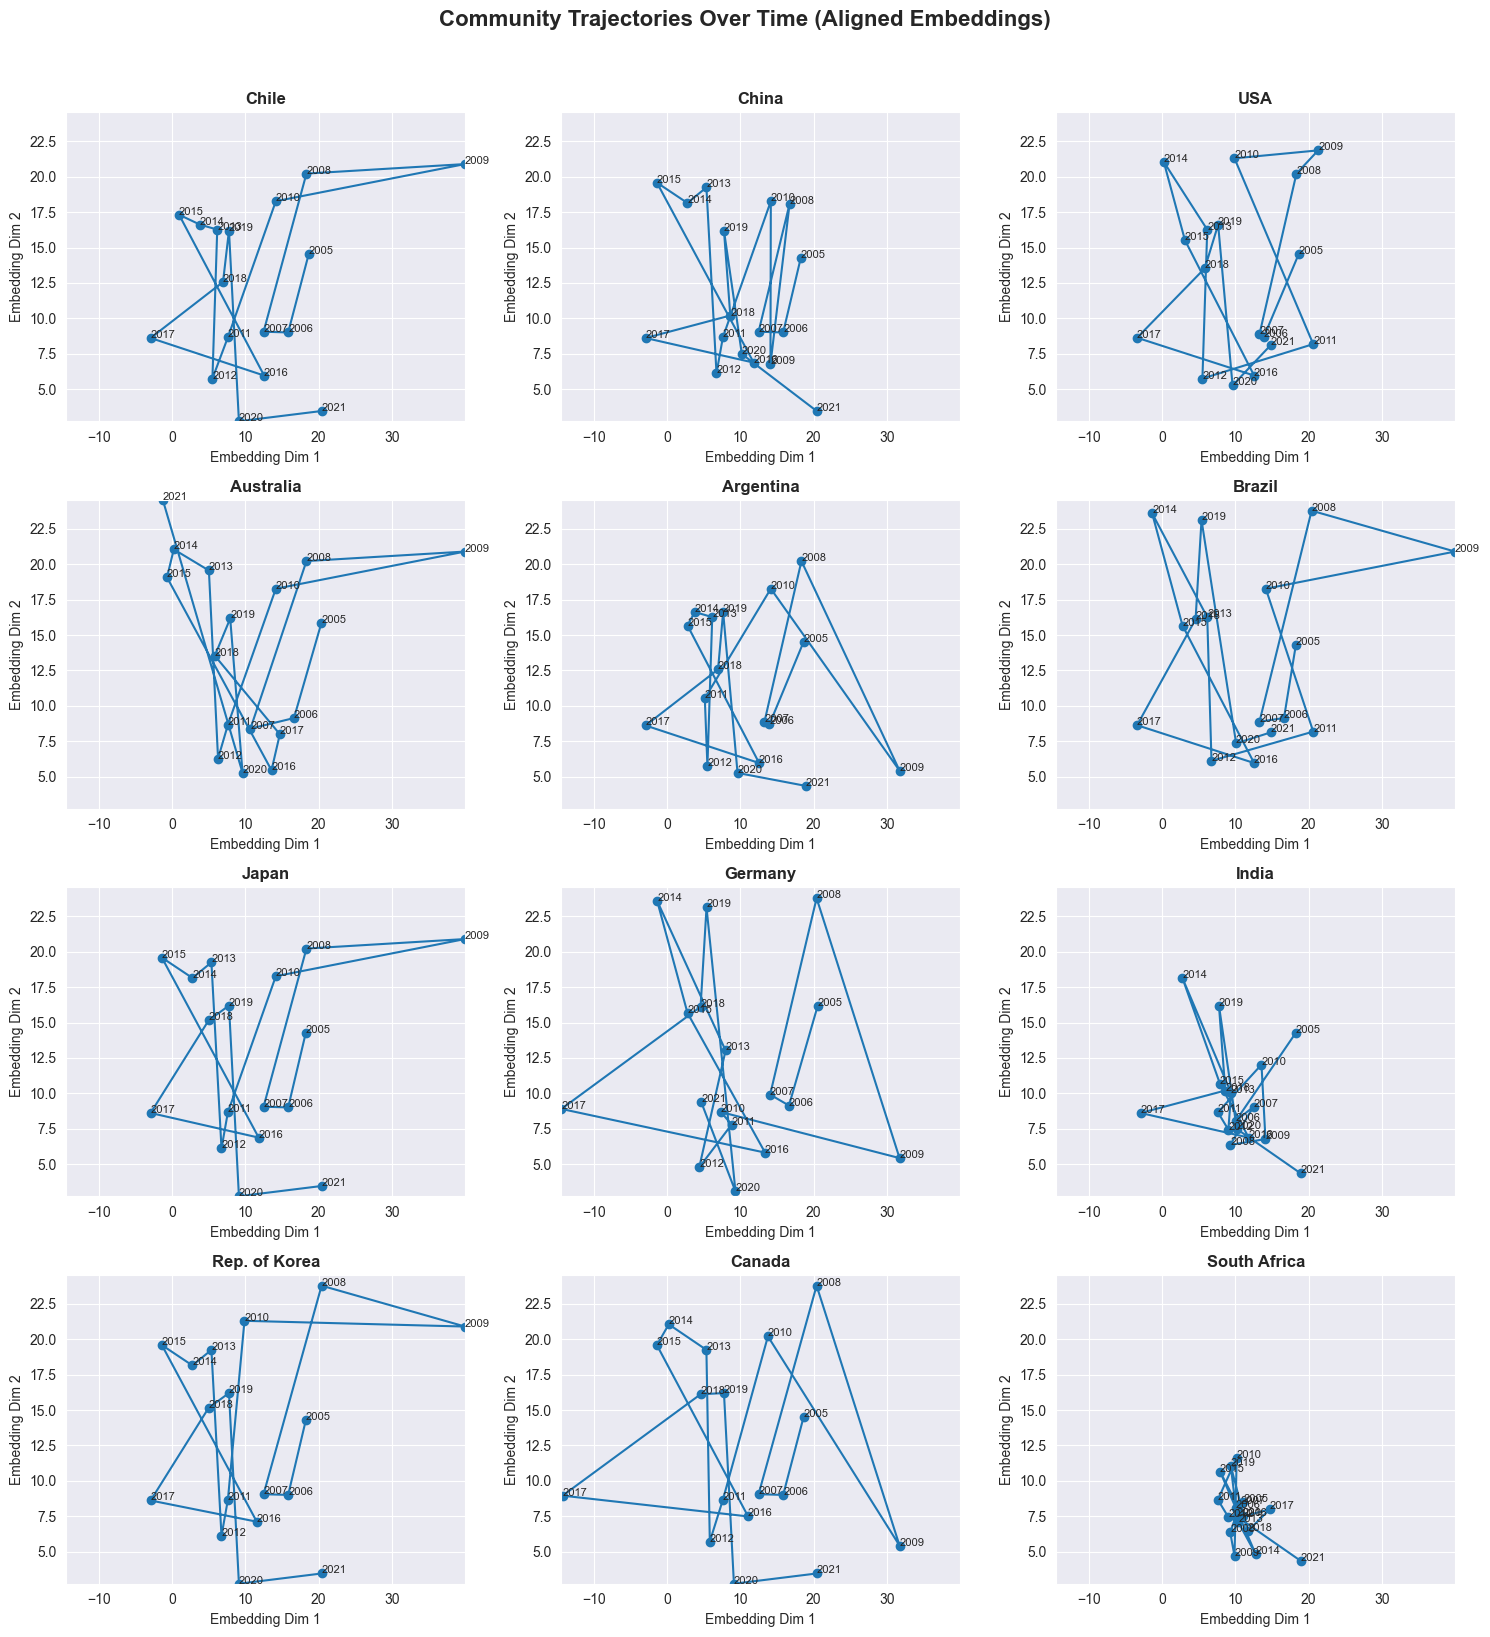

In [13]:


num_nodes = len(all_countries)
embedding_dim = 32
hidden_dim = 64
epochs = 50
lr = 0.01

def build_graph_for_year(year):
    year_df = df[df['t'] == year]
    if year_df.empty:
        data = Data(x=torch.zeros((num_nodes, 2)), edge_index=torch.empty((2,0), dtype=torch.long))
        return data

    x = build_node_features_for_year(year_df, all_countries)
    src = year_df['export_country'].map(country_to_id)
    dst = year_df['import_country'].map(country_to_id)
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)

    attrs = year_df[edge_feature_cols].fillna(0.0).values
    attrs = scaler.transform(attrs)
    edge_attr = torch.tensor(attrs, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

year_graphs = []
for y in years_of_interest:
    year_graphs.append((y, build_graph_for_year(y)))

##############################################
# GCN Encoder for GAE
##############################################
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

##############################################
# Training
##############################################
year_embeddings = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Couldn't make mps work here for some reason

for y, data_y in year_graphs:
    data_y = data_y.to(device)

    encoder = GCNEncoder(in_channels=data_y.x.size(1), hidden_channels=hidden_dim, out_channels=embedding_dim)
    model = GAE(encoder=encoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    rev_edge_index = torch.stack([data_y.edge_index[1], data_y.edge_index[0]], dim=0)
    full_edge_index = torch.cat([data_y.edge_index, rev_edge_index], dim=1)
    data_y.edge_index = full_edge_index

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model.encode(data_y.x, data_y.edge_index)
        loss = model.recon_loss(z, data_y.edge_index)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        z = model.encode(data_y.x, data_y.edge_index)
    year_embeddings[y] = z.cpu().numpy()

##############################################
# Alignment of Embeddings over Time
##############################################
def align_embeddings(ref_emb, target_emb):
    ref_mean = ref_emb.mean(axis=0, keepdims=True)
    tgt_mean = target_emb.mean(axis=0, keepdims=True)
    ref_centered = ref_emb - ref_mean
    tgt_centered = target_emb - tgt_mean
    U, S, Vt = np.linalg.svd(ref_centered.T @ tgt_centered)
    R = U @ Vt
    aligned = (tgt_centered @ R)
    aligned *= (np.linalg.norm(ref_centered) / np.linalg.norm(aligned))
    aligned += ref_mean
    return aligned

ref_year = years_of_interest[0]
ref_emb = year_embeddings[ref_year]
for y in years_of_interest[1:]:
    year_embeddings[y] = align_embeddings(ref_emb, year_embeddings[y])

##############################################
# Community Detection and Tracking
##############################################
year_communities = {}
for y, data_y in year_graphs:
    ei = data_y.edge_index.cpu().numpy() if data_y.edge_index.numel() > 0 else np.empty((2,0),dtype=int)
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for j in range(ei.shape[1]):
        G.add_edge(ei[0,j], ei[1,j])
    comms = nx.algorithms.community.greedy_modularity_communities(G)
    year_communities[y] = comms

def find_community_for_country(comms, cid):
    for i, cset in enumerate(comms):
        if cid in cset:
            return i
    return None

##############################################
# Visualization of Country Trajectory
##############################################
key_countries = [
    "Chile", "China", "USA", "Australia", "Argentina",
    "Brazil", "Japan", "Germany", "India", "Rep. of Korea",
    "Canada", "South Africa"
]

country_ids = {c: country_to_id[c] for c in key_countries if c in country_to_id}

country_trajectories = {}
all_coords = []

for ctry, cid in country_ids.items():
    community_positions_over_time = []
    for y in years_of_interest:
        comms = year_communities[y]
        c_idx = find_community_for_country(comms, cid)
        if c_idx is not None:
            emb = year_embeddings[y]
            c_indices = list(comms[c_idx])
            c_position = emb[c_indices].mean(axis=0)
            community_positions_over_time.append((y, c_position))
    country_trajectories[ctry] = community_positions_over_time

    if len(community_positions_over_time) > 0:
        _, coords = zip(*community_positions_over_time)
        coords = np.array(coords)
        all_coords.append(coords)

if len(all_coords) > 0:
    all_coords_stacked = np.vstack(all_coords)
    x_min = np.nanmin(all_coords_stacked[:,0])
    x_max = np.nanmax(all_coords_stacked[:,0])
    y_min = np.nanmin(all_coords_stacked[:,1])
    y_max = np.nanmax(all_coords_stacked[:,1])

else:
    x_min, x_max, y_min, y_max = -1, 1, -1, 1

num_countries = len(country_trajectories)
cols = 3
rows = (num_countries + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axs = axs.flatten()

for i, (ctry, traj) in enumerate(country_trajectories.items()):
    ax = axs[i]
    if len(traj) > 0:
        ys, coords = zip(*traj)
        coords = np.array(coords)
        ax.plot(coords[:,0], coords[:,1], marker='o')
        for j, yy in enumerate(ys):
            ax.text(coords[j,0], coords[j,1], str(yy), fontsize=8)

        ax.set_title(f"{ctry}", fontweight="bold")
        ax.set_xlabel("Embedding Dim 1")
        ax.set_ylabel("Embedding Dim 2")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    else:
        ax.text(0.5,0.5,"No Data",ha='center',va='center',fontsize=10)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("Embedding Dim 1")
        ax.set_ylabel("Embedding Dim 2")

for k in range(num_countries, rows*cols):
    fig.delaxes(axs[k])

fig.suptitle("Community Trajectories Over Time (Aligned Embeddings)", fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

Community Stability Over Time (NMI):
 [(np.int64(2002), np.int64(2003), np.float64(0.3079150943303561)), (np.int64(2003), np.int64(2004), np.float64(0.127433212791437)), (np.int64(2004), np.int64(2005), np.float64(0.15852141133425693)), (np.int64(2005), np.int64(2006), np.float64(0.20095986472988245)), (np.int64(2006), np.int64(2007), np.float64(0.3583749898749134)), (np.int64(2007), np.int64(2008), np.float64(0.23094676138435313)), (np.int64(2008), np.int64(2009), np.float64(0.25629939865799994)), (np.int64(2009), np.int64(2010), np.float64(0.24433396536145646)), (np.int64(2010), np.int64(2011), np.float64(0.17601412779624925)), (np.int64(2011), np.int64(2012), np.float64(0.3138231464011897)), (np.int64(2012), np.int64(2013), np.float64(0.31761557671717344)), (np.int64(2013), np.int64(2014), np.float64(0.35303769213539576)), (np.int64(2014), np.int64(2015), np.float64(0.37476888011586296)), (np.int64(2015), np.int64(2016), np.float64(0.20670542445634438)), (np.int64(2016), np.int64(20

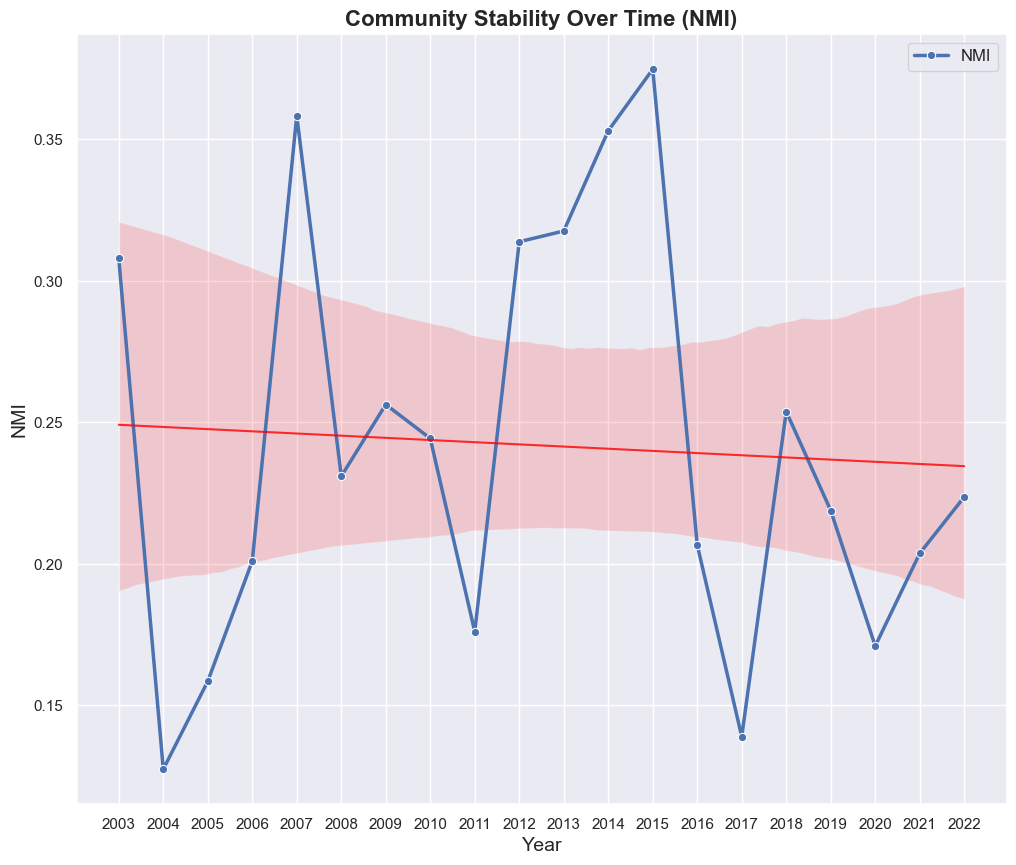

In [14]:


##############################################
# Data Loading
##############################################
cc_df = loader.country_codes.to_pandas()
country_code_to_name = dict(zip(cc_df["country_code"], cc_df["country_name"]))
country_code_to_iso3 = dict(zip(cc_df["country_code"], cc_df["country_iso3"]))

##############################################
# Communities Per Year
##############################################
year_communities = {}
for y, G in yearly_graphs.items():
    comms = greedy_modularity_communities(G, weight='weight')
    node2comm = {}
    for i, cset in enumerate(comms):
        for node in cset:
            node2comm[node] = i
    year_communities[y] = node2comm

##############################################
# Year-to-Year Community Stability (NMI)
##############################################
years_sorted = sorted(yearly_graphs.keys())
stability_results = []
for i in range(len(years_sorted)-1):
    y1, y2 = years_sorted[i], years_sorted[i+1]
    common_nodes = set(year_communities[y1].keys()).intersection(year_communities[y2].keys())
    c1 = [year_communities[y1][n] for n in common_nodes]
    c2 = [year_communities[y2][n] for n in common_nodes]
    nmi = normalized_mutual_info_score(c1, c2)
    stability_results.append((y1, y2, nmi))

print("Community Stability Over Time (NMI):\n", stability_results)

##############################################
# Visualization
##############################################
nmi_df = pd.DataFrame(stability_results, columns=['year_start', 'year_end', 'NMI'])
nmi_df['year'] = nmi_df['year_end']

plt.figure(figsize=(12, 10))
sns.set_theme(style="darkgrid")

sns.lineplot(x='year', y='NMI', data=nmi_df, marker='o', linewidth=2.5, label='NMI')
sns.regplot(x='year', y='NMI', data=nmi_df, scatter=False,
            line_kws={'color': 'red', 'lw': 1.5, 'alpha':0.8})

plt.title("Community Stability Over Time (NMI)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.xticks(nmi_df["year"].unique().astype(int))
plt.ylabel("NMI", fontsize=14)
plt.legend(fontsize=12)

Intra-Community Trade Ratio Over Time:
 [(np.int64(2002), 0.5767354563241525), (np.int64(2003), 0.580190733133207), (np.int64(2004), 0.6126494858191425), (np.int64(2005), 0.6361511820818214), (np.int64(2006), 0.5321130316333584), (np.int64(2007), 0.6607941757234326), (np.int64(2008), 0.6038212613898888), (np.int64(2009), 0.6160040771563469), (np.int64(2010), 0.6557791668107102), (np.int64(2011), 0.6670712861049807), (np.int64(2012), 0.6649195610651842), (np.int64(2013), 0.6247132223165967), (np.int64(2014), 0.59430349478764), (np.int64(2015), 0.5943208750939316), (np.int64(2016), 0.6430614896304023), (np.int64(2017), 0.6963090070039022), (np.int64(2018), 0.7155275630364042), (np.int64(2019), 0.8714628602239763), (np.int64(2020), 0.8185099623735703), (np.int64(2021), 0.7979872442987744), (np.int64(2022), 0.8603347825540052)]


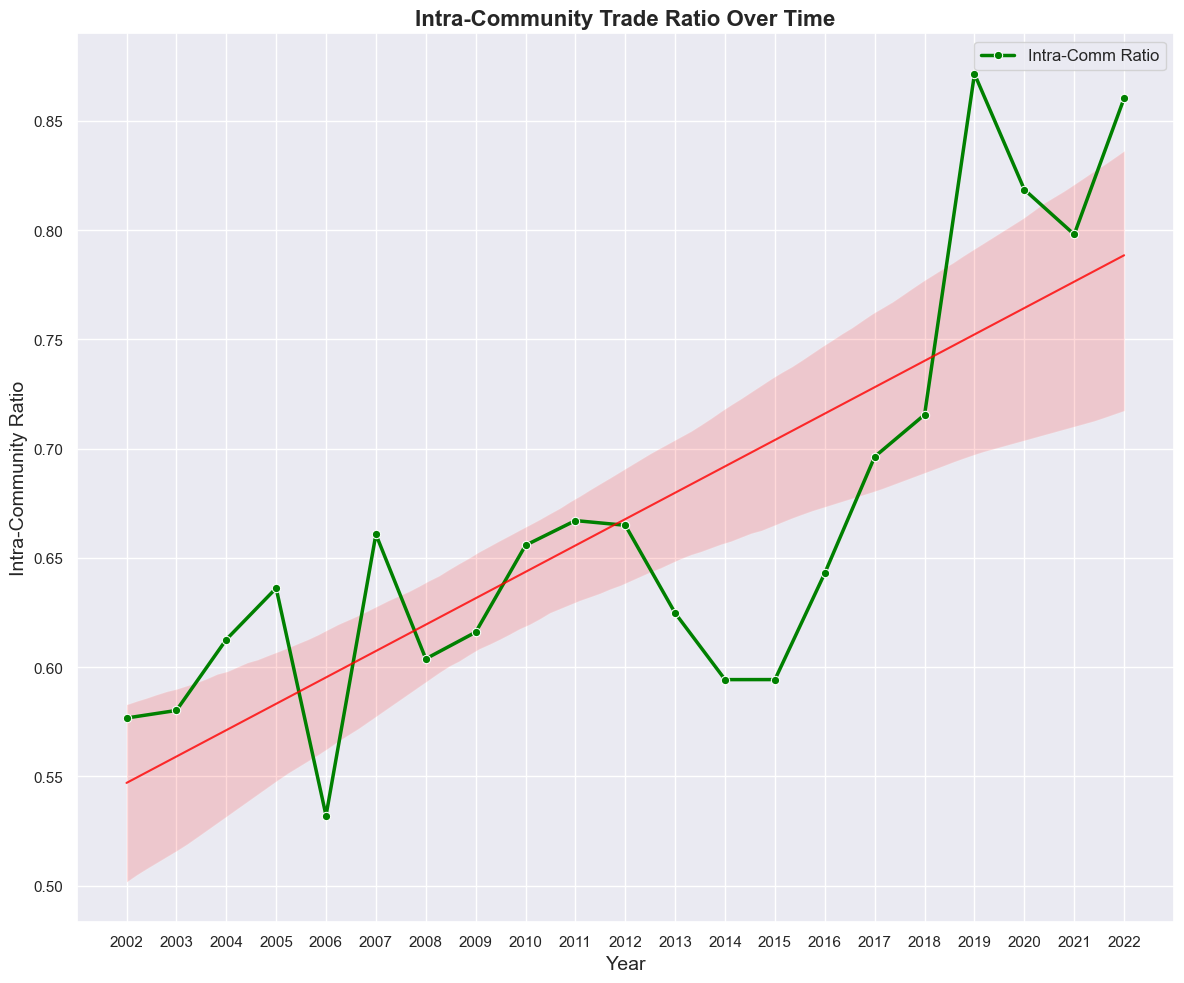

In [15]:
##############################################
# Compute Intra-Community Trade Ratio per Year
##############################################
intra_ratios = []
for y, G in yearly_graphs.items():
    comm_map = year_communities[y]
    intra_weight = 0.0
    inter_weight = 0.0

    for u, v, d in G.edges(data=True):
        if comm_map.get(u) == comm_map.get(v):
            intra_weight += d.get('weight', 0)
        else:
            inter_weight += d.get('weight', 0)

    total_weight = intra_weight + inter_weight
    if total_weight > 0:
        ratio = intra_weight / total_weight
        intra_ratios.append((y, ratio))

print("Intra-Community Trade Ratio Over Time:\n", intra_ratios)

intra_df = pd.DataFrame(intra_ratios, columns=['year', 'intra_ratio'])

##############################################
# Visualization
##############################################
plt.figure(figsize=(12, 10))
sns.set_theme(style="darkgrid")
sns.lineplot(x='year', y='intra_ratio', data=intra_df, marker='o', linewidth=2.5, color='green', label='Intra-Comm Ratio')
sns.regplot(x='year', y='intra_ratio', data=intra_df, scatter=False,
            line_kws={'color': 'red', 'lw': 1.5, 'alpha':0.8})

plt.title("Intra-Community Trade Ratio Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.xticks(intra_df["year"].unique().astype(int))
plt.ylabel("Intra-Community Ratio", fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

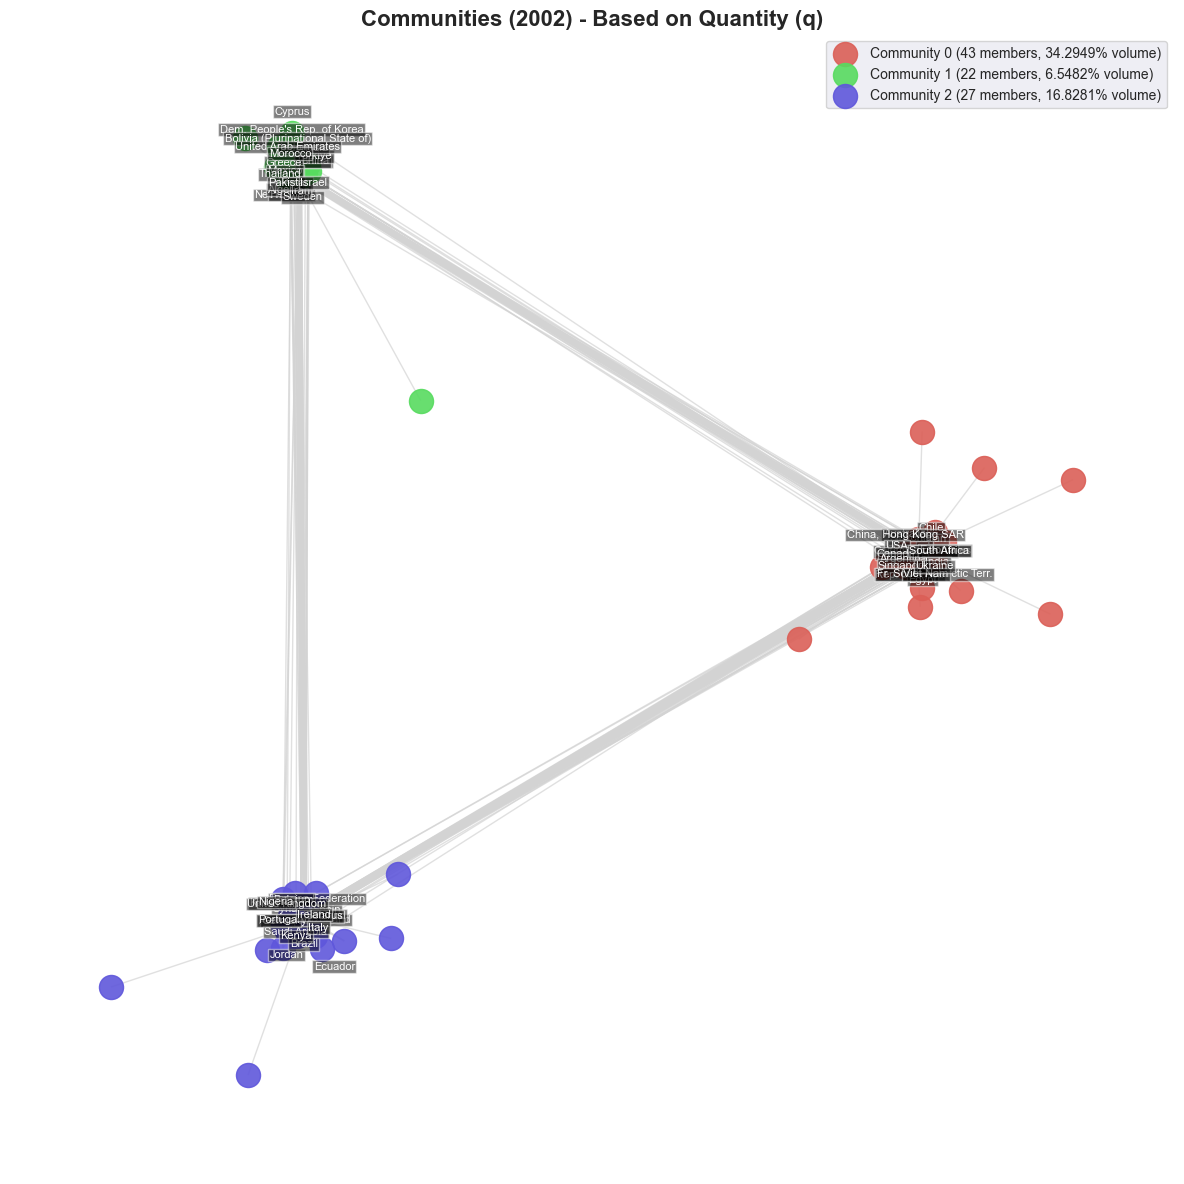

Top Countries by Community based on q for year 0.022683697368004824:
Community 0:
  USA | Japan | India | South Africa | Rep. of Korea | Other Asia, nes | Australia | Canada | China, Hong Kong SAR | Singapore | Ukraine | Slovenia | Estonia | Argentina | Egypt | Colombia | Fr. South Antarctic Terr. | Czechia | Chile | Viet Nam
Community 1:
  China | Netherlands | France | Sweden | Thailand | Mexico | Türkiye | Indonesia | Israel | Tunisia | Peru | Iran | United Arab Emirates | Algeria | Greece | Morocco | Bolivia (Plurinational State of) | Pakistan | Dem. People's Rep. of Korea | Cyprus
Community 2:
  Belgium | Russian Federation | Germany | United Kingdom | Spain | Italy | Switzerland | Poland | Saudi Arabia | Brazil | Austria | Kenya | Jordan | Belarus | Syria | Nigeria | Ireland | Kazakhstan | Portugal | Ecuador


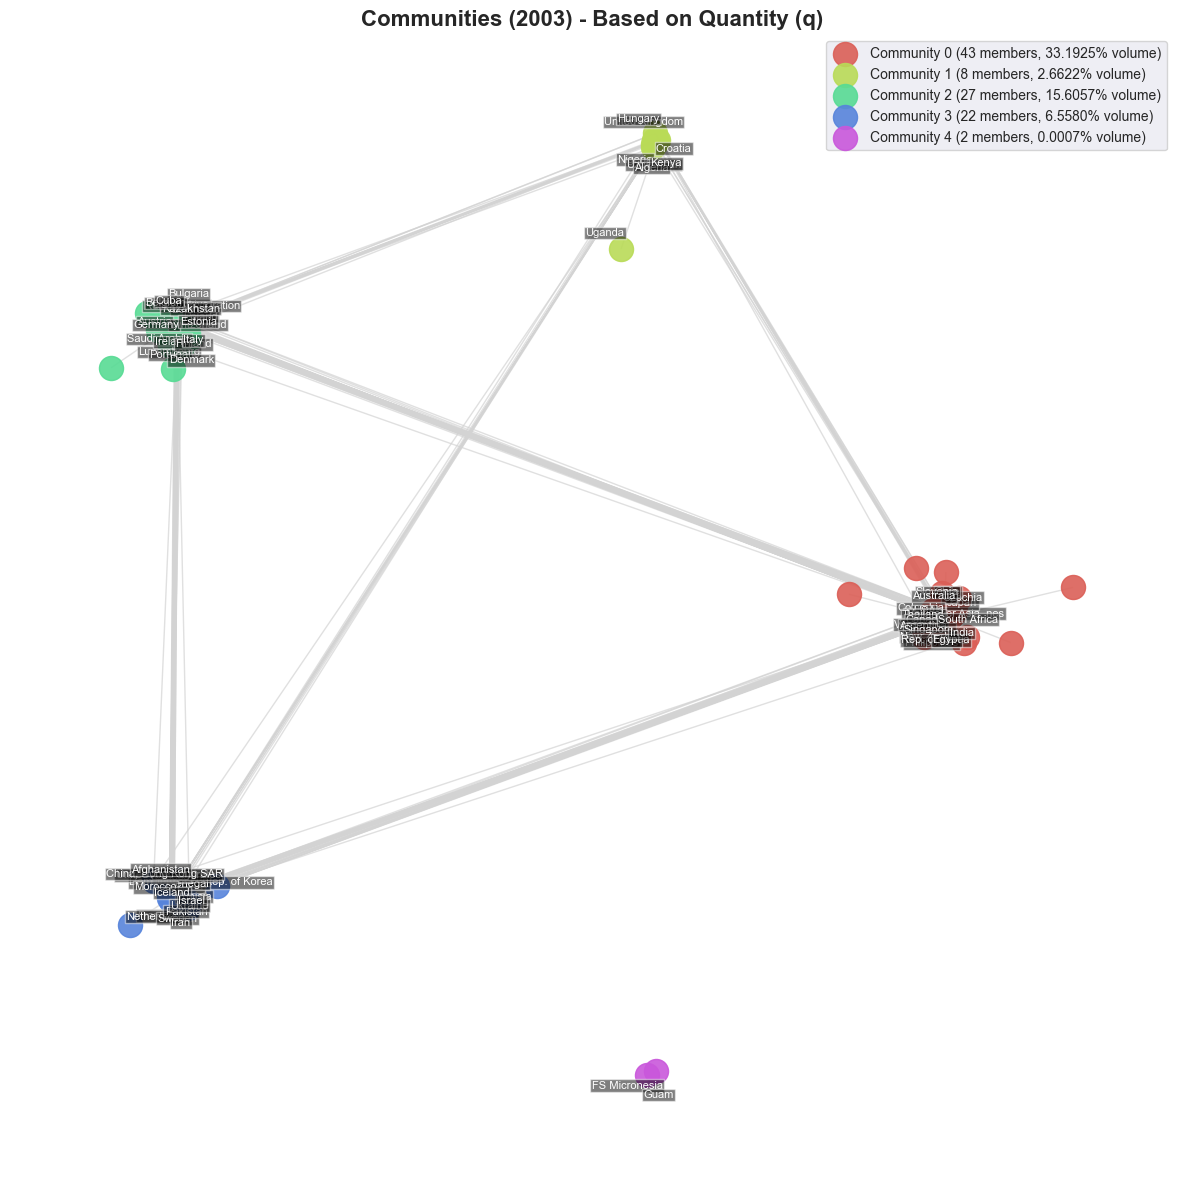

Top Countries by Community based on q for year -0.015131711920173697:
Community 0:
  USA | Japan | India | Rep. of Korea | South Africa | Australia | New Zealand | Canada | Other Asia, nes | Thailand | Singapore | Argentina | Mexico | Chile | Slovenia | Egypt | Czechia | Colombia | Venezuela | Philippines
Community 1:
  United Kingdom | Kenya | Uzbekistan | Croatia | Hungary | Algeria | Nigeria | Uganda
Community 2:
  Germany | Belgium | Russian Federation | Spain | Italy | Saudi Arabia | Türkiye | Switzerland | Poland | Austria | Finland | Estonia | Cuba | Bulgaria | Luxembourg | Belarus | Ireland | Portugal | Kazakhstan | Denmark
Community 3:
  China | France | Netherlands | Sweden | Ukraine | United Arab Emirates | Israel | China, Hong Kong SAR | Iran | Greece | Pakistan | Morocco | Kuwait | Indonesia | Tunisia | Dem. People's Rep. of Korea | Afghanistan | Syria | Senegal | Iceland
Community 4:
  Guam | FS Micronesia


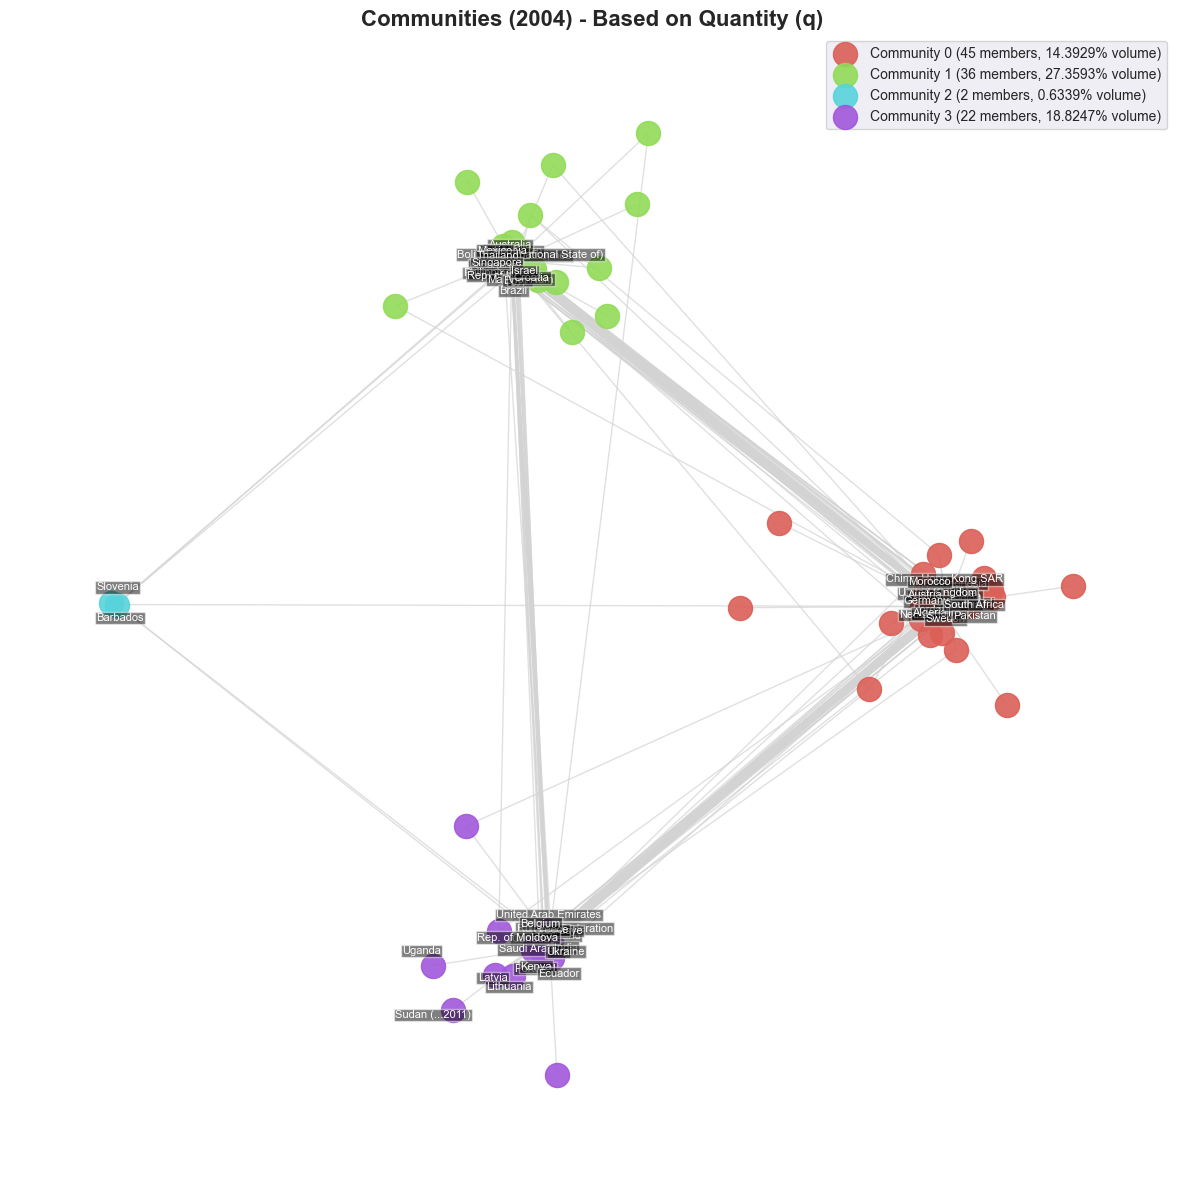

Top Countries by Community based on q for year 0.0015574480559759664:
Community 0:
  Germany | China | United Kingdom | France | Netherlands | Spain | South Africa | Sweden | Switzerland | Romania | Chile | Jordan | Czechia | Austria | Indonesia | China, Hong Kong SAR | Iran | Pakistan | Morocco | Algeria
Community 1:
  USA | Japan | Rep. of Korea | Malaysia | Australia | Argentina | Mexico | New Zealand | Thailand | Other Asia, nes | Singapore | Egypt | Viet Nam | Philippines | Colombia | Israel | Venezuela | Croatia | Brazil | Bolivia (Plurinational State of)
Community 2:
  Slovenia | Barbados
Community 3:
  Belgium | Russian Federation | India | Canada | Poland | Saudi Arabia | Italy | Türkiye | Ukraine | United Arab Emirates | Greece | Belarus | Portugal | Kenya | Ecuador | Rep. of Moldova | Latvia | Lithuania | Uganda | Sudan (...2011)


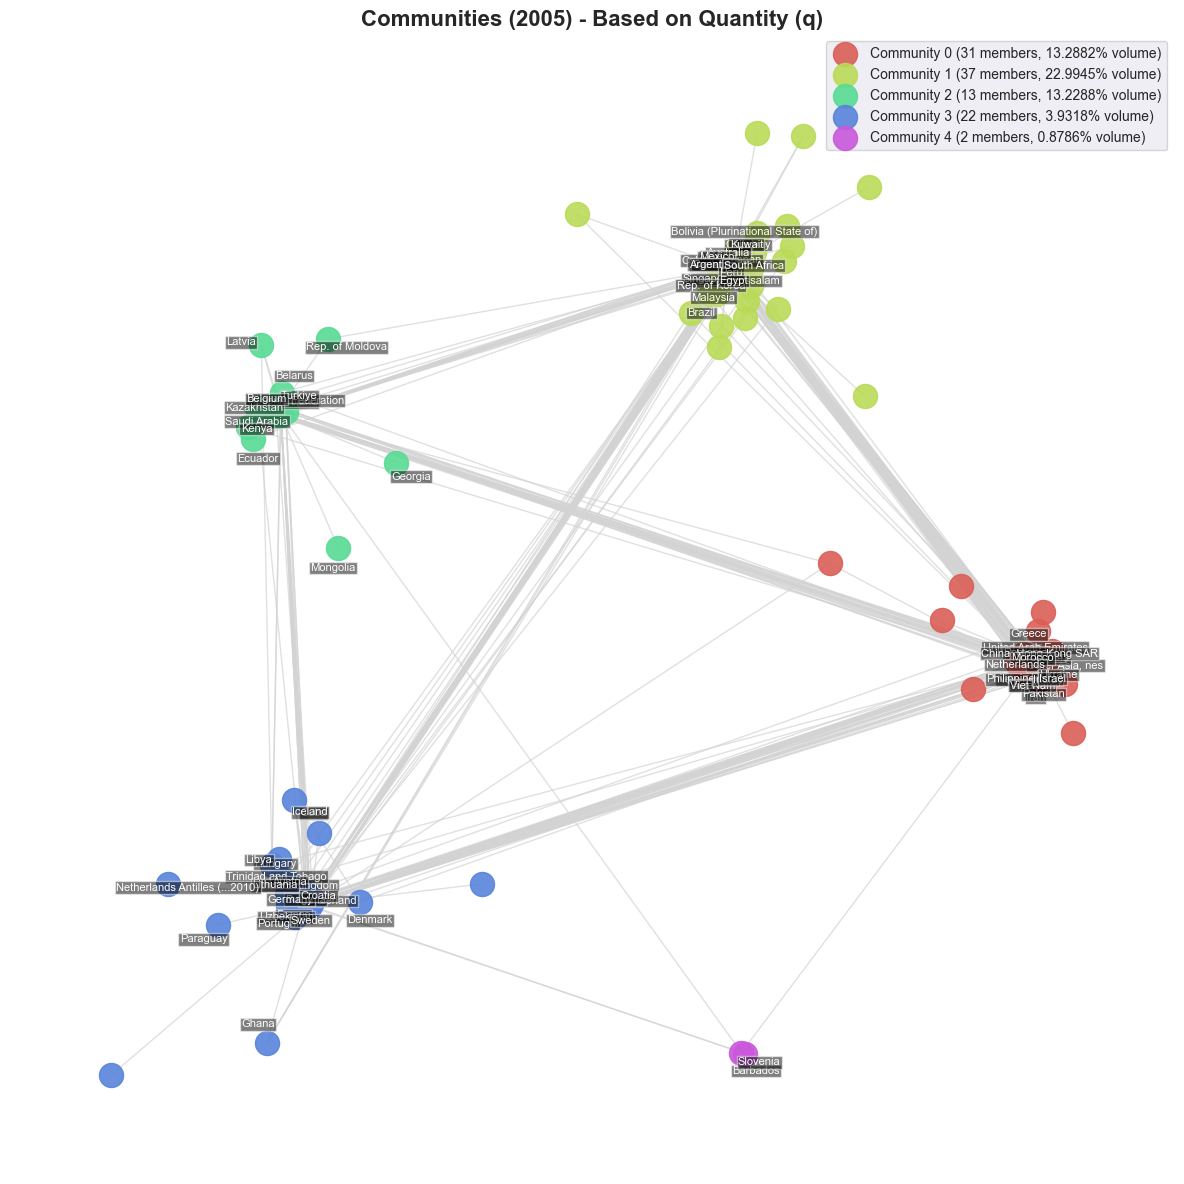

Top Countries by Community based on q for year 1.9177325481434493:
Community 0:
  China | India | Spain | Netherlands | United Arab Emirates | Italy | Czechia | Ukraine | Algeria | Philippines | Greece | Other Asia, nes | Viet Nam | China, Hong Kong SAR | Israel | Iran | Pakistan | New Zealand | Romania | Morocco
Community 1:
  USA | Japan | Rep. of Korea | South Africa | Canada | Chile | Argentina | Australia | Mexico | Thailand | Singapore | Malaysia | Colombia | Egypt | Norway | Brunei Darussalam | Kuwait | Bolivia (Plurinational State of) | Peru | Brazil
Community 2:
  Belgium | Russian Federation | Poland | Türkiye | Saudi Arabia | Belarus | Kenya | Kazakhstan | Ecuador | Latvia | Rep. of Moldova | Georgia | Mongolia
Community 3:
  Germany | United Kingdom | France | Sweden | Switzerland | Uzbekistan | Austria | Bulgaria | Croatia | Portugal | Trinidad and Tobago | Hungary | Lithuania | Denmark | Libya | Cuba | Paraguay | Iceland | Netherlands Antilles (...2010) | Ghana
Community 

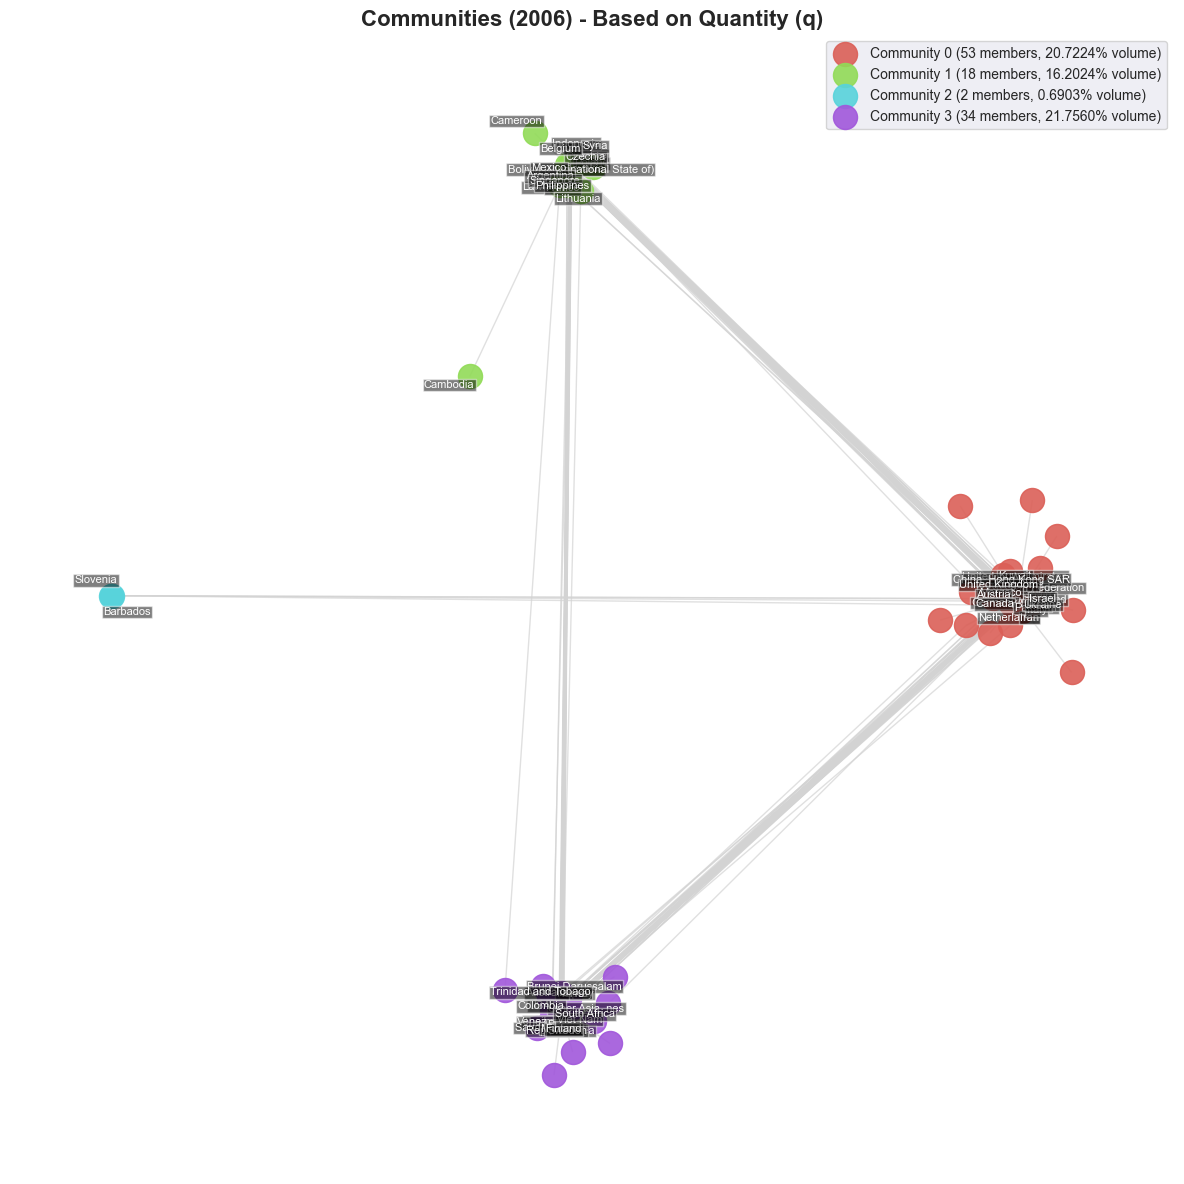

Top Countries by Community based on q for year -2.0061498168890823:
Community 0:
  Germany | China | Russian Federation | India | Netherlands | Spain | United Kingdom | Canada | Italy | United Arab Emirates | Switzerland | Iran | Austria | Ukraine | Greece | Morocco | Pakistan | Israel | China, Hong Kong SAR | Kuwait
Community 1:
  Chile | Belgium | France | Türkiye | Poland | Argentina | Singapore | Mexico | Philippines | Czechia | Indonesia | Lithuania | Slovakia | Latvia | Syria | Bolivia (Plurinational State of) | Cameroon | Cambodia
Community 2:
  Slovenia | Barbados
Community 3:
  USA | Japan | Rep. of Korea | South Africa | Thailand | Other Asia, nes | Sweden | Malaysia | Australia | Egypt | Saudi Arabia | Colombia | Venezuela | Viet Nam | Brunei Darussalam | Norway | Brazil | Peru | Finland | Trinidad and Tobago


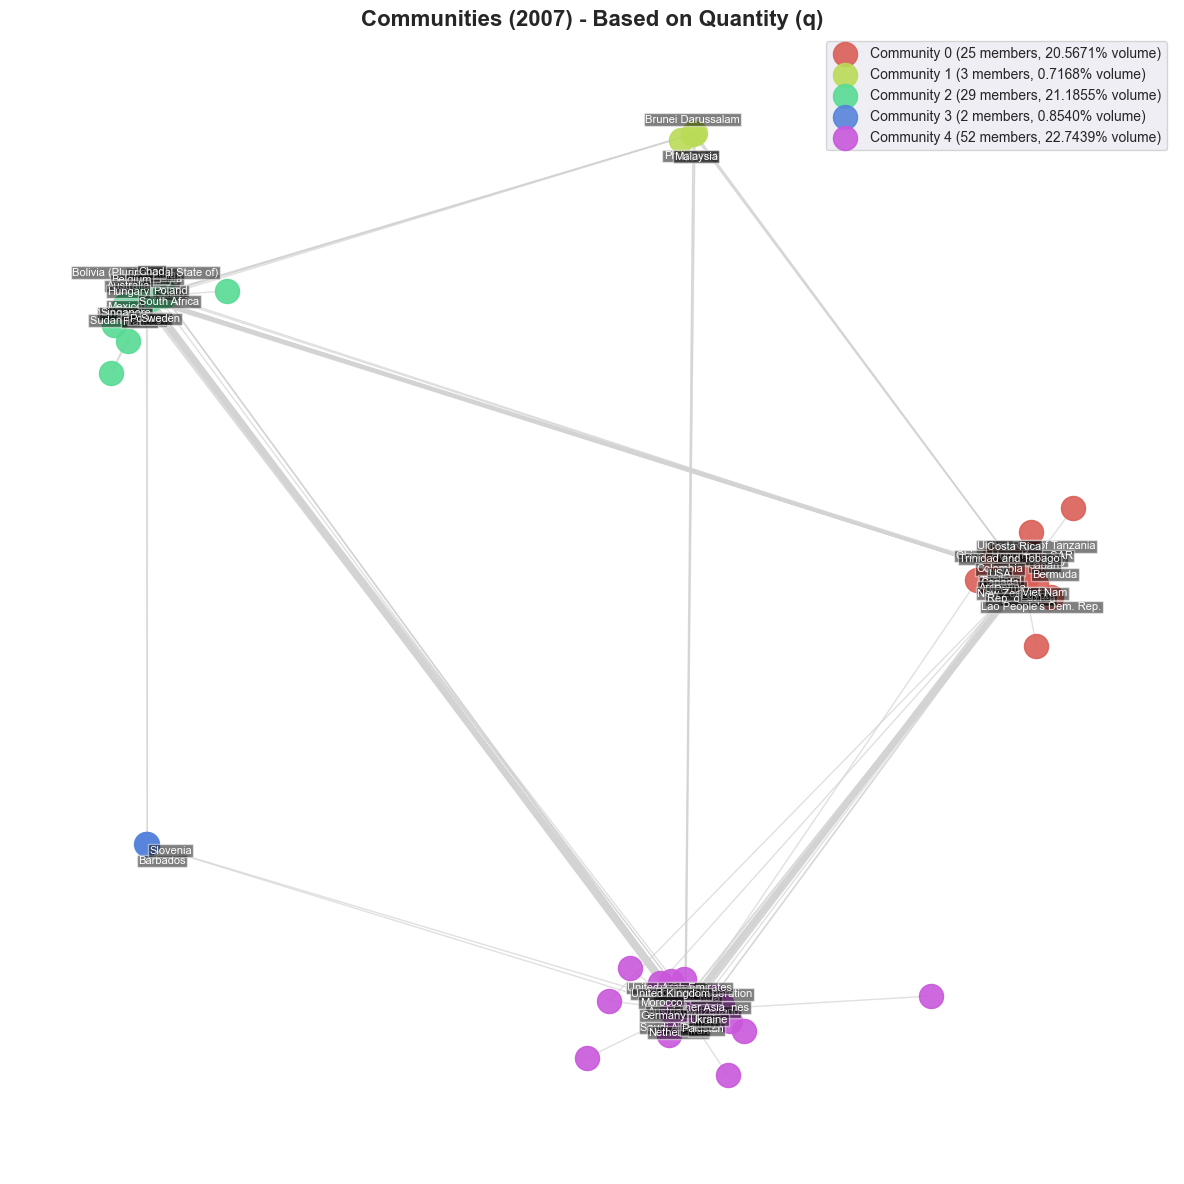

Top Countries by Community based on q for year 1.18979921474564:
Community 0:
  USA | Japan | Rep. of Korea | Argentina | Canada | Thailand | China, Hong Kong SAR | Colombia | Egypt | Viet Nam | New Zealand | Peru | Ghana | Trinidad and Tobago | Norway | Bermuda | Lao People's Dem. Rep. | United Rep. of Tanzania | Costa Rica | Cambodia
Community 1:
  Philippines | Malaysia | Brunei Darussalam
Community 2:
  Chile | Belgium | Spain | France | Türkiye | South Africa | Poland | Australia | Mexico | Singapore | Sweden | Indonesia | Czechia | Venezuela | Portugal | Hungary | Syria | Bolivia (Plurinational State of) | Chad | Sudan (...2011)
Community 3:
  Slovenia | Barbados
Community 4:
  China | Germany | India | Netherlands | Russian Federation | United Kingdom | Italy | Other Asia, nes | Switzerland | United Arab Emirates | Ukraine | Iran | Saudi Arabia | Greece | Brazil | Pakistan | Kuwait | Austria | Morocco | Romania


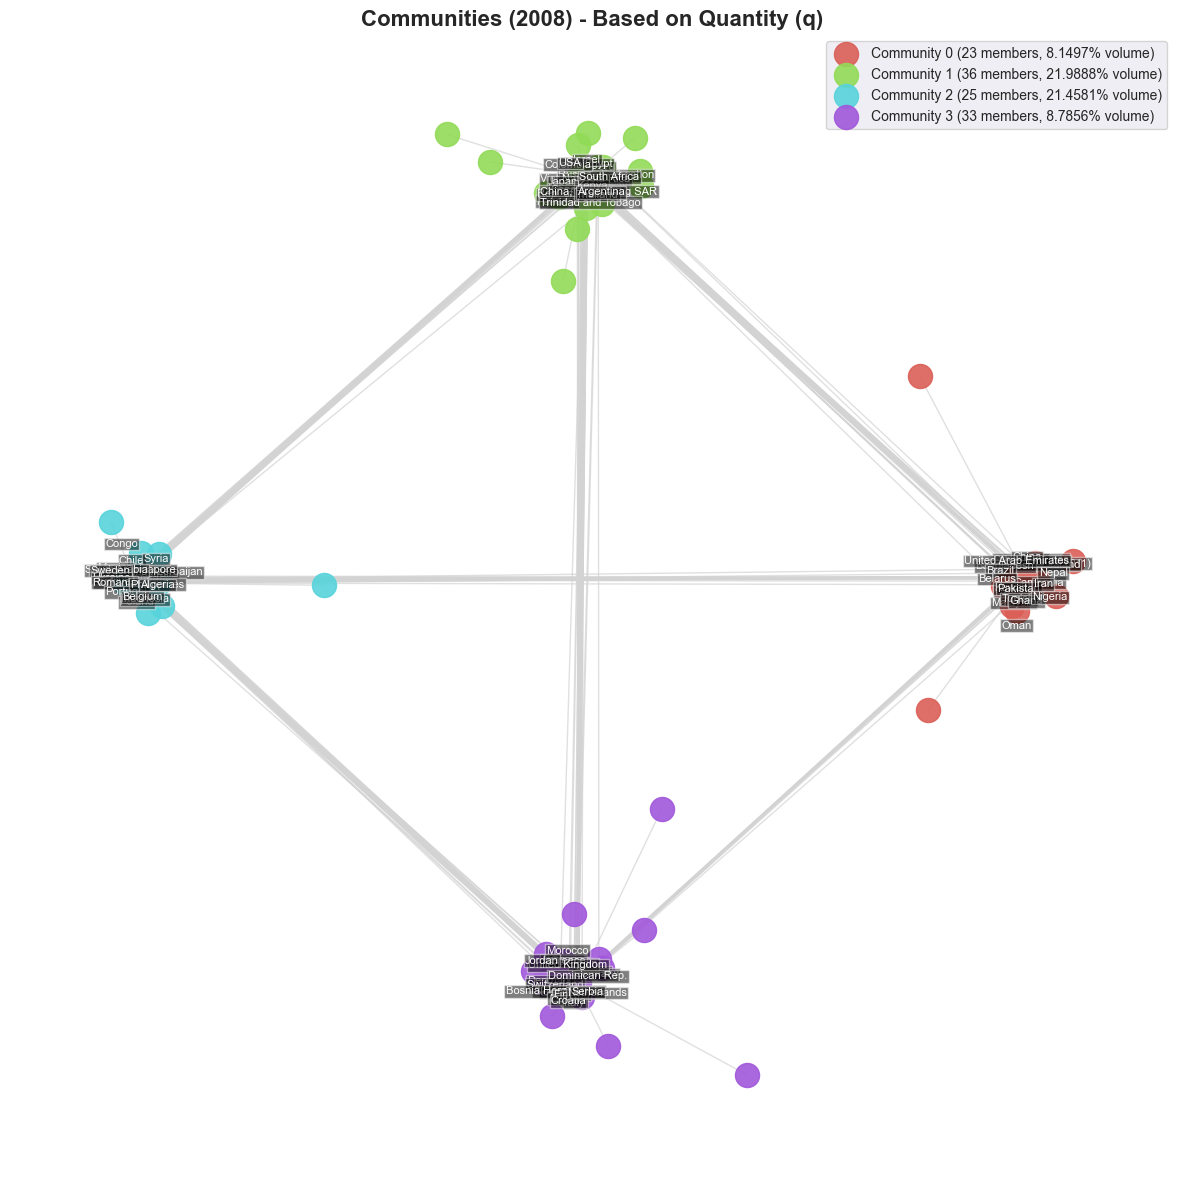

Top Countries by Community based on q for year 2.0252890807085393:
Community 0:
  China | India | Other Asia, nes | United Arab Emirates | Brazil | Kuwait | Iran | Belarus | Tunisia | Ghana | Malaysia | Pakistan | New Zealand | Nigeria | Sudan (...2011) | Nepal | Bangladesh | Oman | Cambodia | Cyprus
Community 1:
  USA | Japan | Rep. of Korea | Russian Federation | Argentina | South Africa | Thailand | Canada | China, Hong Kong SAR | Colombia | Venezuela | Egypt | Viet Nam | Israel | Peru | Norway | Costa Rica | Trinidad and Tobago | Panama | Kenya
Community 2:
  Chile | Belgium | Türkiye | Mexico | Saudi Arabia | Australia | Singapore | Sweden | Algeria | Ukraine | Poland | Czechia | Philippines | Indonesia | Portugal | Romania | Cuba | Syria | Azerbaijan | Congo
Community 3:
  Germany | Netherlands | Spain | United Kingdom | France | Italy | Switzerland | Slovenia | Greece | Austria | Denmark | Finland | Croatia | Serbia | Bosnia Herzegovina | Ecuador | Bulgaria | Morocco | Dominican

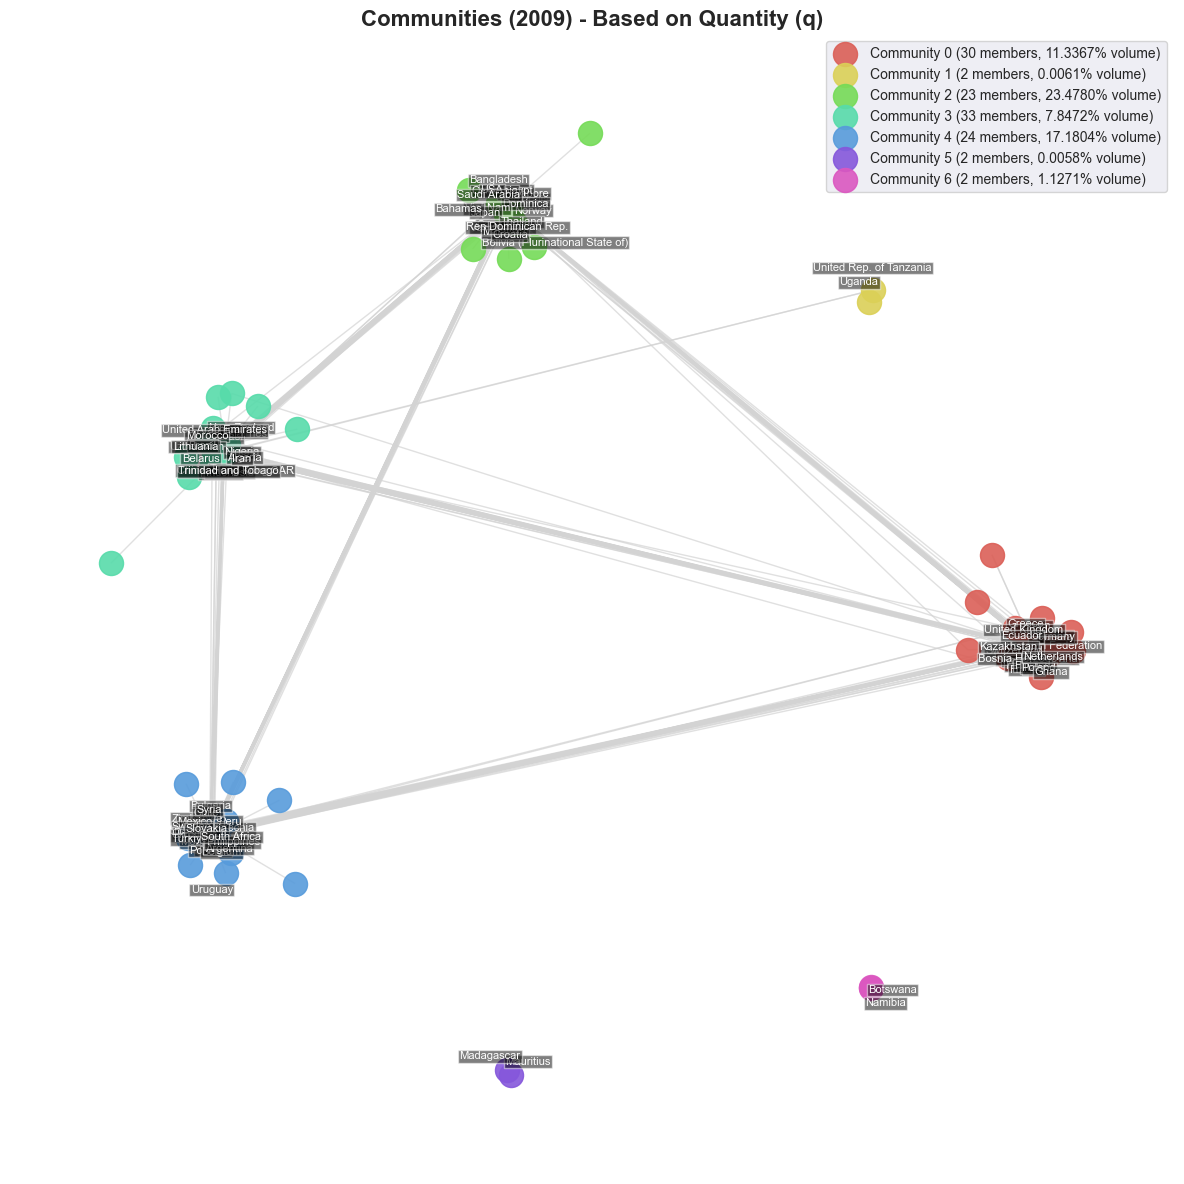

Top Countries by Community based on q for year -0.8769649979741162:
Community 0:
  Germany | United Kingdom | Netherlands | Spain | France | Russian Federation | Switzerland | Slovenia | Poland | Italy | Austria | Greece | Finland | Romania | Hungary | Ghana | Bosnia Herzegovina | Ecuador | Kazakhstan | Angola
Community 1:
  United Rep. of Tanzania | Uganda
Community 2:
  USA | Japan | Rep. of Korea | Saudi Arabia | Thailand | Singapore | Australia | Canada | Venezuela | Egypt | Colombia | Malaysia | Viet Nam | Norway | Croatia | Bangladesh | Dominican Rep. | Dominica | Bahamas | Bolivia (Plurinational State of)
Community 3:
  China | India | Algeria | China, Hong Kong SAR | United Arab Emirates | Other Asia, nes | Indonesia | Brazil | Iran | Pakistan | Belarus | Morocco | Tunisia | Israel | New Zealand | Lithuania | Cuba | Uzbekistan | Nigeria | Trinidad and Tobago
Community 4:
  Chile | Belgium | Türkiye | South Africa | Ukraine | Argentina | Sweden | Mexico | Philippines | Czechia |

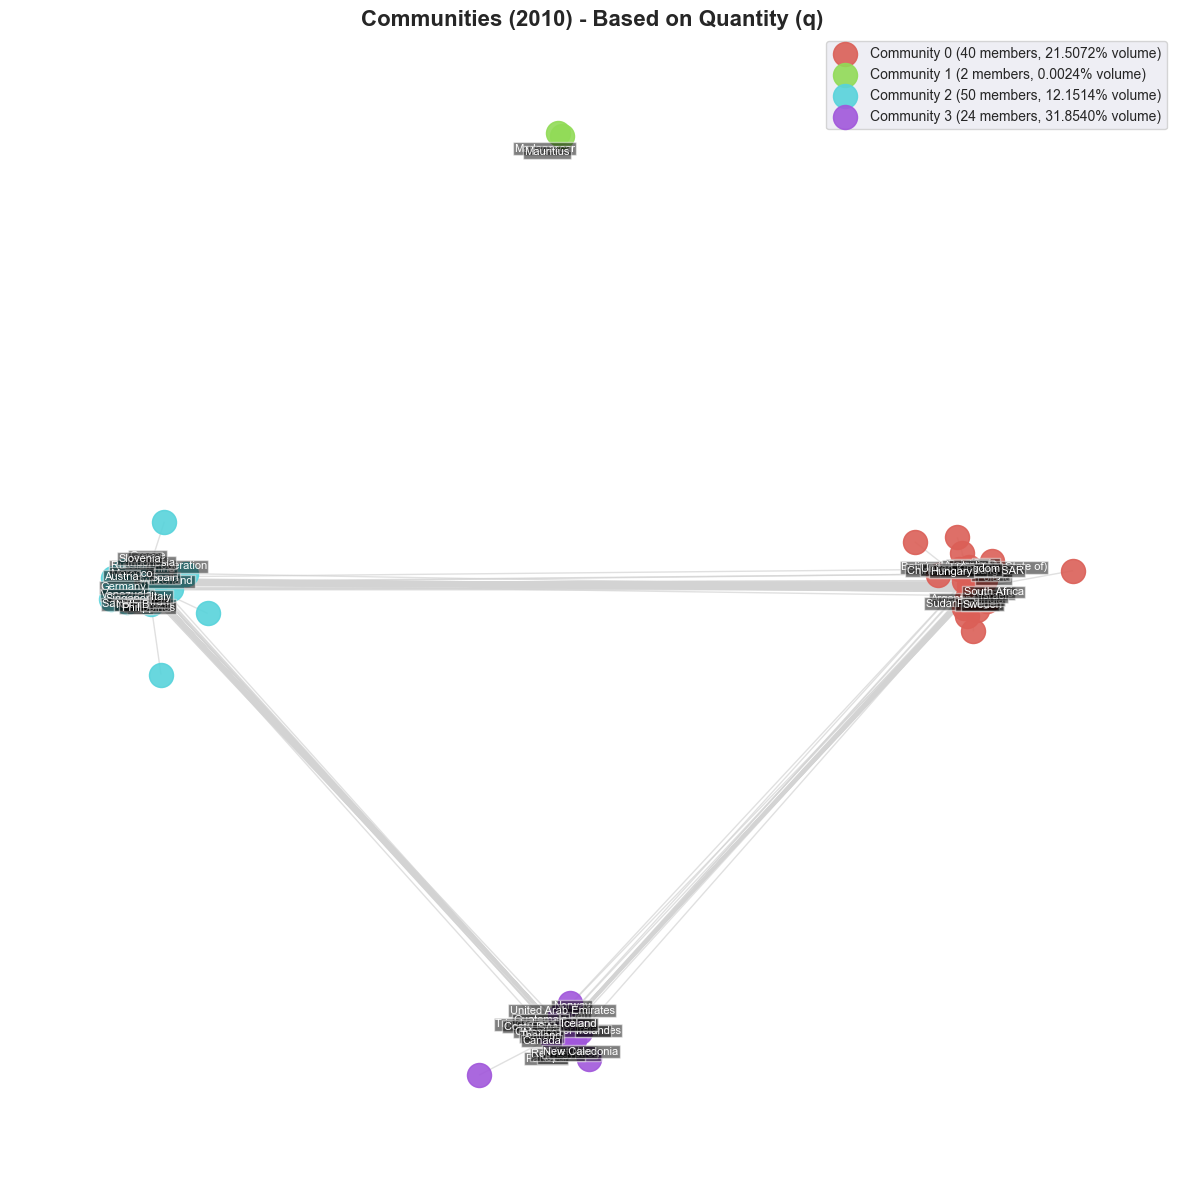

Top Countries by Community based on q for year -0.021822885347175382:
Community 0:
  Chile | Belgium | India | United Kingdom | Türkiye | South Africa | Argentina | Ukraine | Australia | Poland | Sweden | China, Hong Kong SAR | Romania | Czechia | Sudan (...2011) | Israel | Portugal | Syria | Bolivia (Plurinational State of) | Hungary
Community 1:
  Mauritius | Madagascar
Community 2:
  China | Germany | Spain | France | Russian Federation | Netherlands | Saudi Arabia | Singapore | Italy | Iran | Switzerland | Slovenia | Brazil | Philippines | Venezuela | Indonesia | Peru | Austria | Morocco | Greece
Community 3:
  USA | Japan | Rep. of Korea | Other Asia, nes | Thailand | Canada | Mexico | United Arab Emirates | Egypt | Colombia | Viet Nam | Nepal | Norway | New Caledonia | Trinidad and Tobago | Guatemala | Iceland | Panama | Costa Rica | Ireland


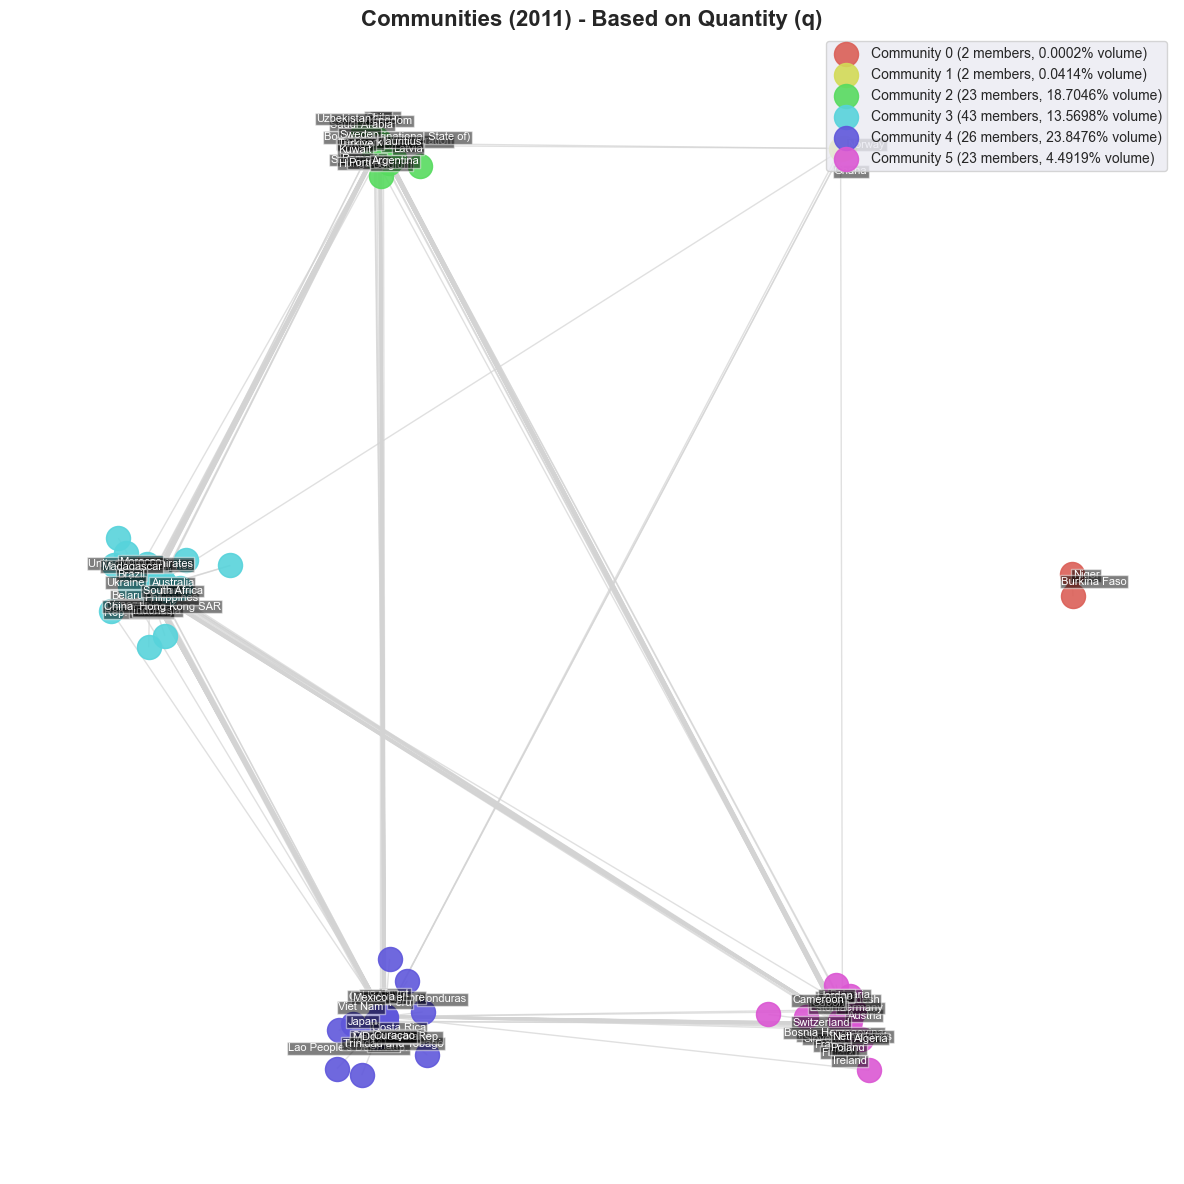

Top Countries by Community based on q for year -0.01563448900196855:
Community 0:
  Niger | Burkina Faso
Community 1:
  Norway | Ghana
Community 2:
  Chile | Belgium | Russian Federation | Spain | United Kingdom | Türkiye | Saudi Arabia | Argentina | Sweden | Czechia | Romania | Portugal | Bolivia (Plurinational State of) | Hungary | Kuwait | Denmark | Slovakia | Mauritius | Latvia | Uzbekistan
Community 3:
  China | India | Rep. of Korea | Other Asia, nes | South Africa | Australia | United Arab Emirates | Iran | Indonesia | Ukraine | Philippines | Brazil | Venezuela | China, Hong Kong SAR | Madagascar | Belarus | Tunisia | Morocco | Pakistan | Syria
Community 4:
  USA | Japan | Canada | Thailand | Mexico | Singapore | Egypt | Colombia | Viet Nam | Dominican Rep. | Malaysia | Peru | Israel | Trinidad and Tobago | Serbia | Oman | Curaçao | Costa Rica | Lao People's Dem. Rep. | Honduras
Community 5:
  Germany | Netherlands | France | Switzerland | Italy | Slovenia | Poland | Austria | G

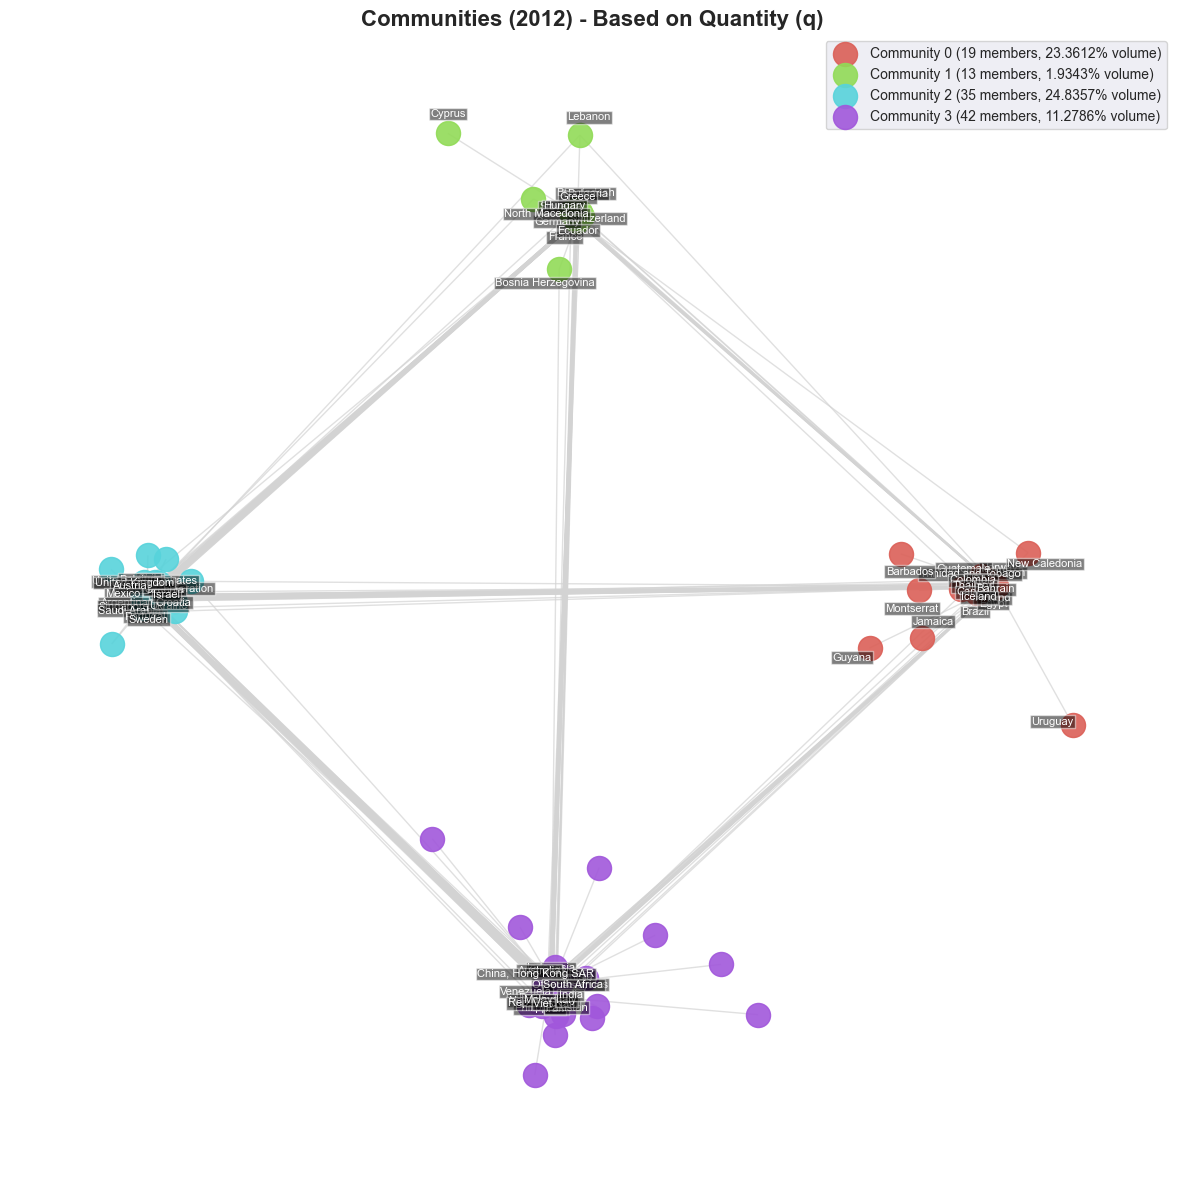

Top Countries by Community based on q for year -1.993518762821386:
Community 0:
  USA | Japan | Canada | Thailand | Colombia | Egypt | Trinidad and Tobago | Norway | Finland | Guatemala | Bahrain | Brazil | Iceland | New Caledonia | Montserrat | Jamaica | Barbados | Guyana | Uruguay
Community 1:
  Germany | France | Slovenia | Switzerland | Greece | Hungary | Bulgaria | Ecuador | Bangladesh | North Macedonia | Bosnia Herzegovina | Lebanon | Cyprus
Community 2:
  Belgium | Chile | Russian Federation | United Kingdom | Spain | Türkiye | Singapore | Saudi Arabia | United Arab Emirates | Sweden | Poland | Argentina | Mexico | Ukraine | Romania | Czechia | Austria | Portugal | Israel | Croatia
Community 3:
  China | India | Rep. of Korea | Netherlands | Other Asia, nes | South Africa | Italy | Australia | Iran | Indonesia | China, Hong Kong SAR | Kuwait | Venezuela | Peru | Malaysia | Tunisia | Philippines | Viet Nam | Syria | Pakistan


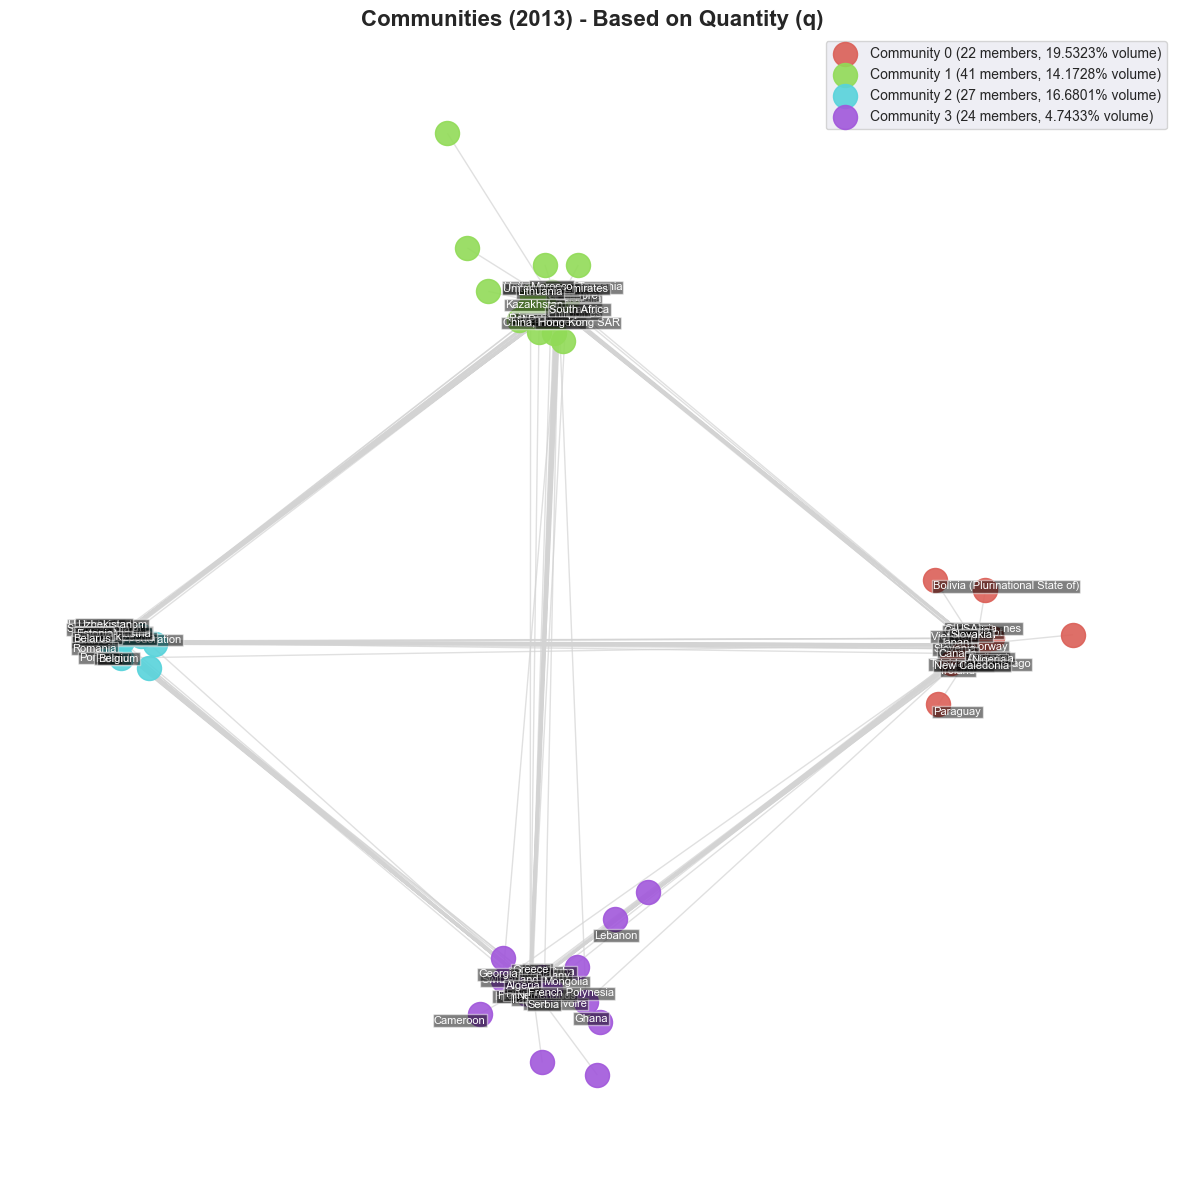

Top Countries by Community based on q for year 1.9502708305092142:
Community 0:
  USA | Japan | Canada | Other Asia, nes | Thailand | Slovenia | Argentina | Egypt | Colombia | Viet Nam | Nigeria | Brazil | Tunisia | Trinidad and Tobago | Norway | Slovakia | Ireland | New Caledonia | Bolivia (Plurinational State of) | Paraguay
Community 1:
  China | India | Rep. of Korea | United Arab Emirates | South Africa | Iran | Australia | Singapore | Indonesia | Venezuela | Malaysia | Israel | United Rep. of Tanzania | Pakistan | Philippines | China, Hong Kong SAR | Peru | Morocco | Lithuania | Kazakhstan
Community 2:
  Chile | Belgium | Russian Federation | United Kingdom | Türkiye | Saudi Arabia | Mexico | Sweden | Poland | Ukraine | Czechia | Romania | Austria | Portugal | Estonia | Denmark | Sudan | Qatar | Belarus | Uzbekistan
Community 3:
  Germany | Netherlands | Spain | France | Switzerland | Italy | Greece | Hungary | Bulgaria | Finland | Serbia | Côte d'Ivoire | Cuba | French Polynesia 

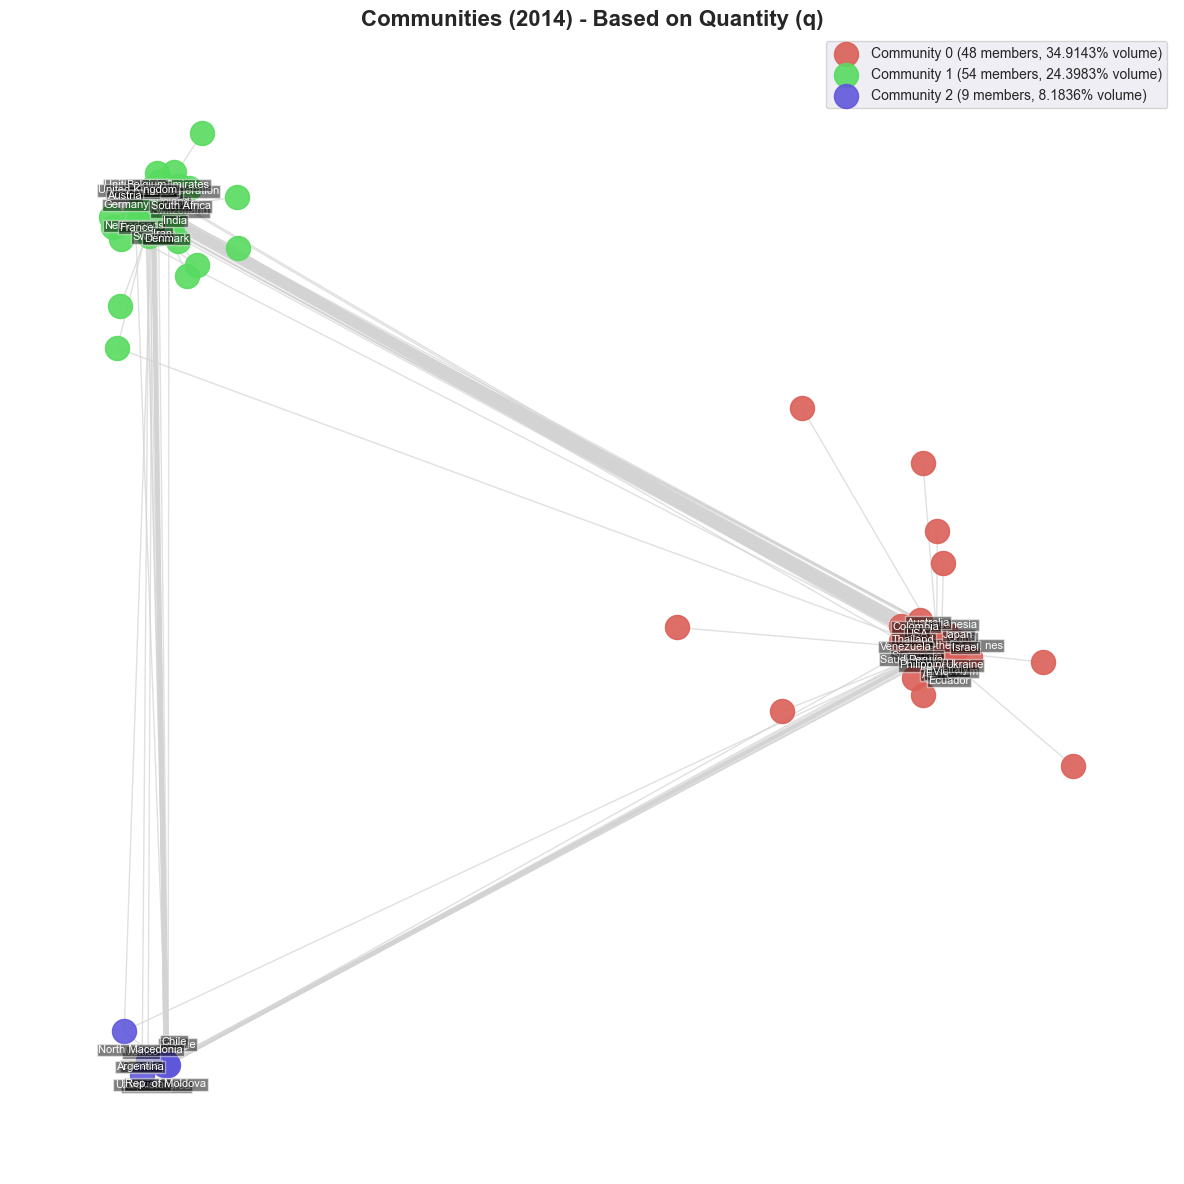

Top Countries by Community based on q for year 1.7820996587586977:
Community 0:
  USA | Japan | China | Other Asia, nes | Thailand | Singapore | Saudi Arabia | Italy | Australia | Ukraine | Egypt | Philippines | Indonesia | Peru | Colombia | Venezuela | Viet Nam | Israel | Algeria | Ecuador
Community 1:
  Belgium | Russian Federation | Germany | India | Netherlands | United Kingdom | France | Spain | United Arab Emirates | Slovenia | South Africa | Sweden | Poland | Iran | Switzerland | Austria | Romania | Greece | Denmark | Czechia
Community 2:
  Chile | Rep. of Korea | Canada | Türkiye | Argentina | Mexico | Uzbekistan | Rep. of Moldova | North Macedonia


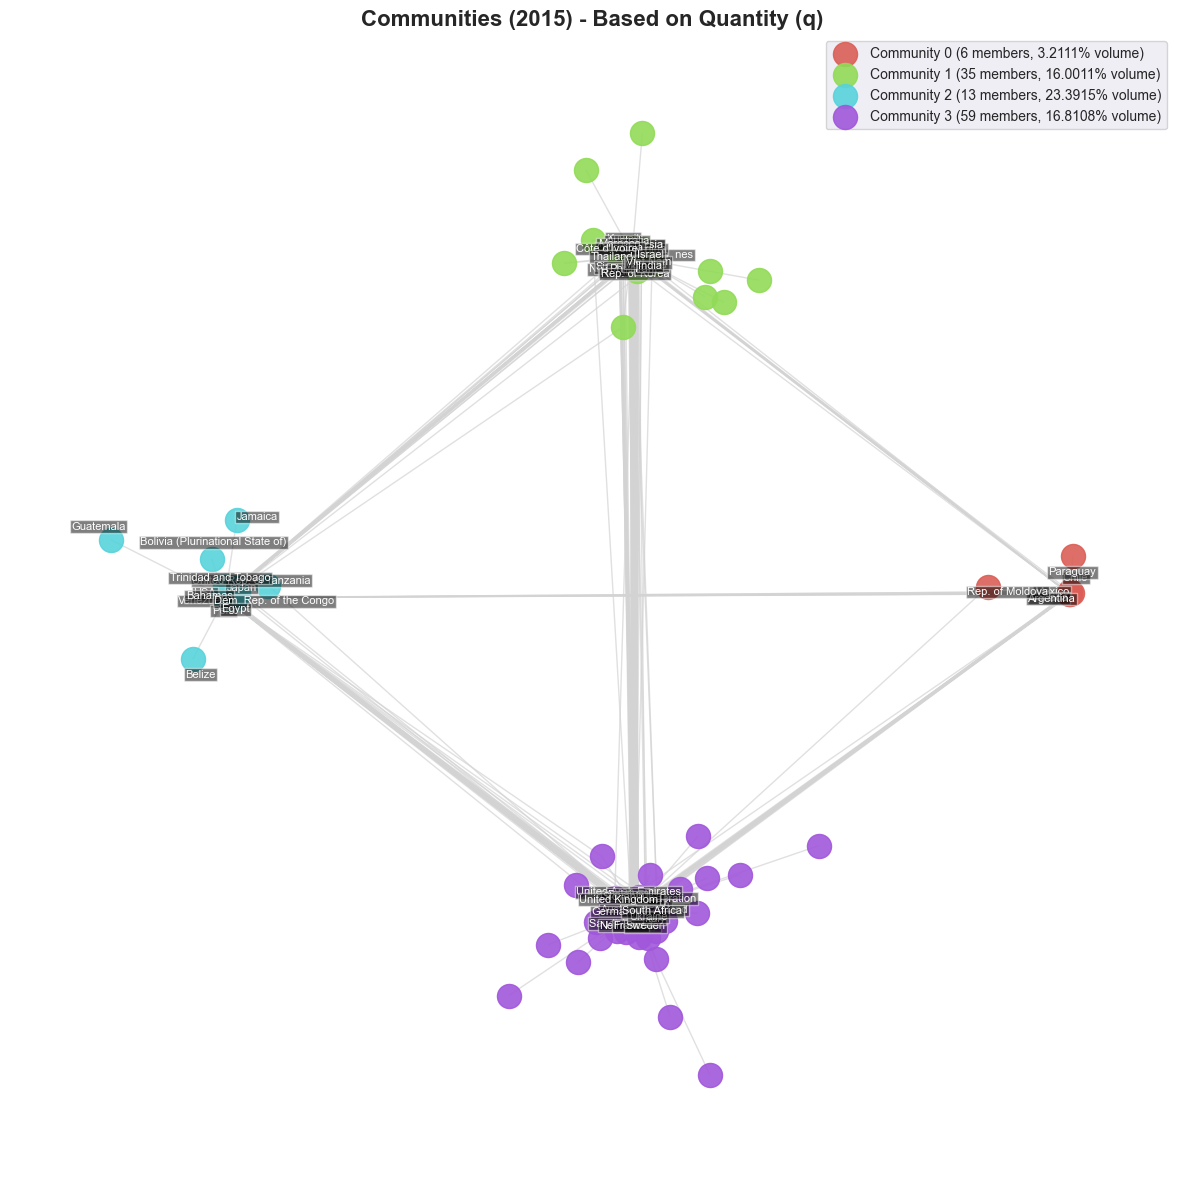

Top Countries by Community based on q for year -1.9612883933965028:
Community 0:
  Chile | Canada | Argentina | Mexico | Paraguay | Rep. of Moldova
Community 1:
  China | Rep. of Korea | India | Other Asia, nes | Thailand | Singapore | Australia | Iran | Indonesia | Colombia | Morocco | Kuwait | Philippines | Côte d'Ivoire | Israel | Viet Nam | Tunisia | Nepal | Nigeria | Malaysia
Community 2:
  USA | Japan | Venezuela | Egypt | Peru | United Rep. of Tanzania | Bahamas | Trinidad and Tobago | Dem. Rep. of the Congo | Bolivia (Plurinational State of) | Belize | Jamaica | Guatemala
Community 3:
  Belgium | Russian Federation | Germany | Netherlands | France | Spain | United Arab Emirates | United Kingdom | South Africa | Slovenia | Türkiye | Saudi Arabia | Sweden | Switzerland | Poland | Italy | Ukraine | Austria | Czechia | Greece


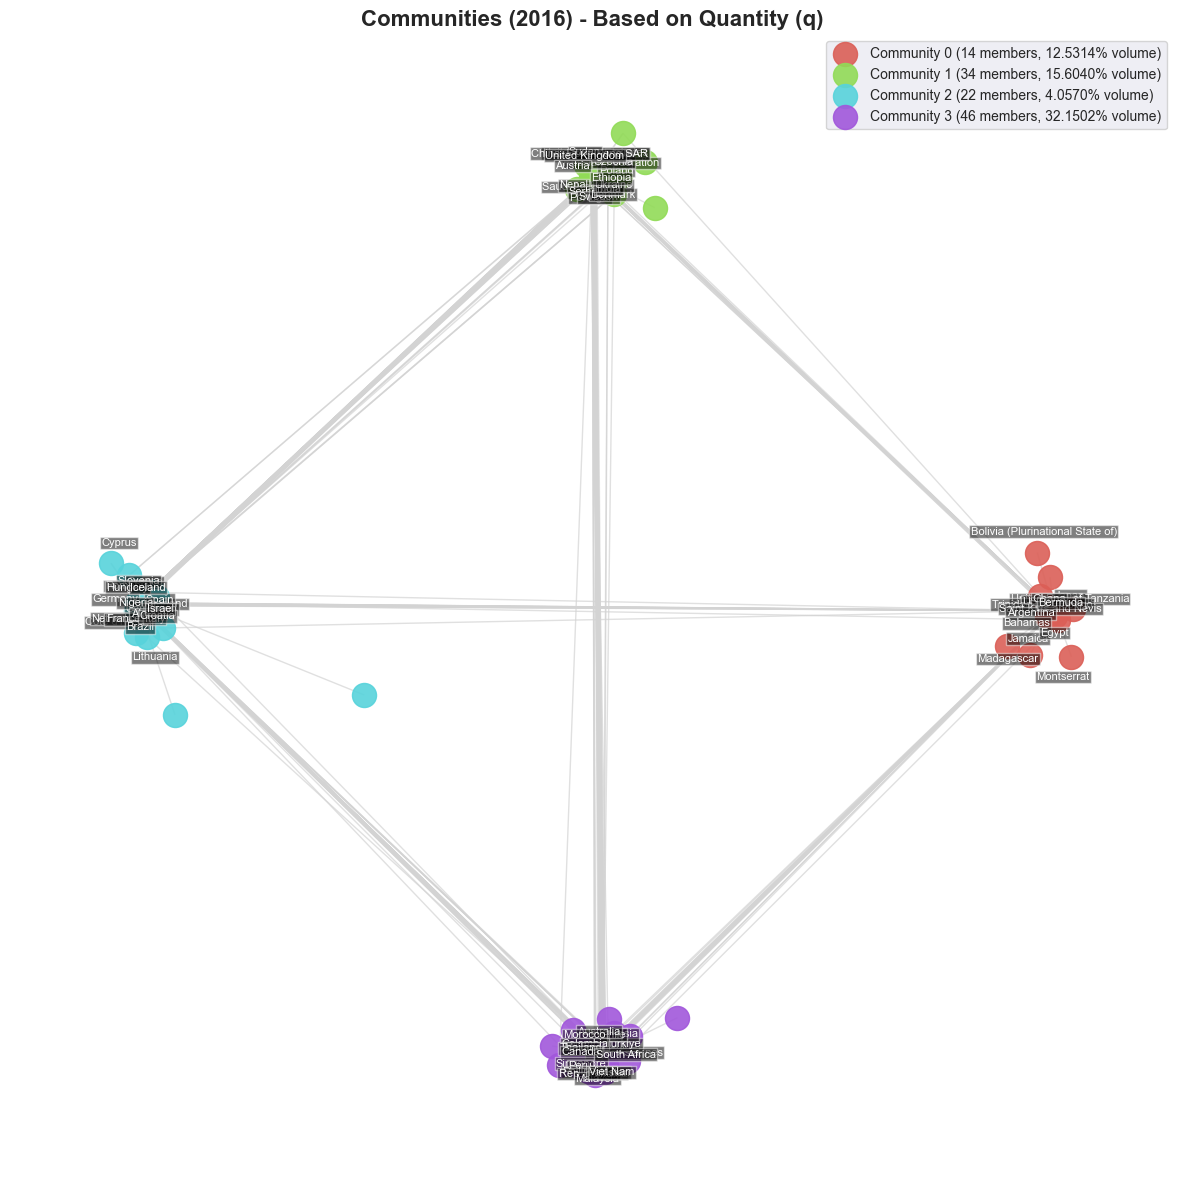

Top Countries by Community based on q for year -2.0026580821954076:
Community 0:
  USA | Japan | Argentina | Egypt | United Rep. of Tanzania | Bahamas | Trinidad and Tobago | Saint Kitts and Nevis | Bermuda | Ghana | Montserrat | Madagascar | Jamaica | Bolivia (Plurinational State of)
Community 1:
  Belgium | Russian Federation | India | United Arab Emirates | United Kingdom | Sweden | Poland | Saudi Arabia | Ukraine | China, Hong Kong SAR | Sudan | Austria | Czechia | Qatar | Portugal | Nepal | Belarus | Serbia | Denmark | Ethiopia
Community 2:
  Germany | Netherlands | France | Spain | Slovenia | Italy | Switzerland | Israel | Romania | Brazil | Greece | Hungary | Croatia | Algeria | Nigeria | Iceland | Côte d'Ivoire | Lithuania | Cameroon | Cyprus
Community 3:
  China | Rep. of Korea | Chile | Canada | Other Asia, nes | Thailand | Türkiye | Singapore | South Africa | Indonesia | Iran | Mexico | Australia | Philippines | Colombia | Viet Nam | Peru | Malaysia | Morocco | Pakistan


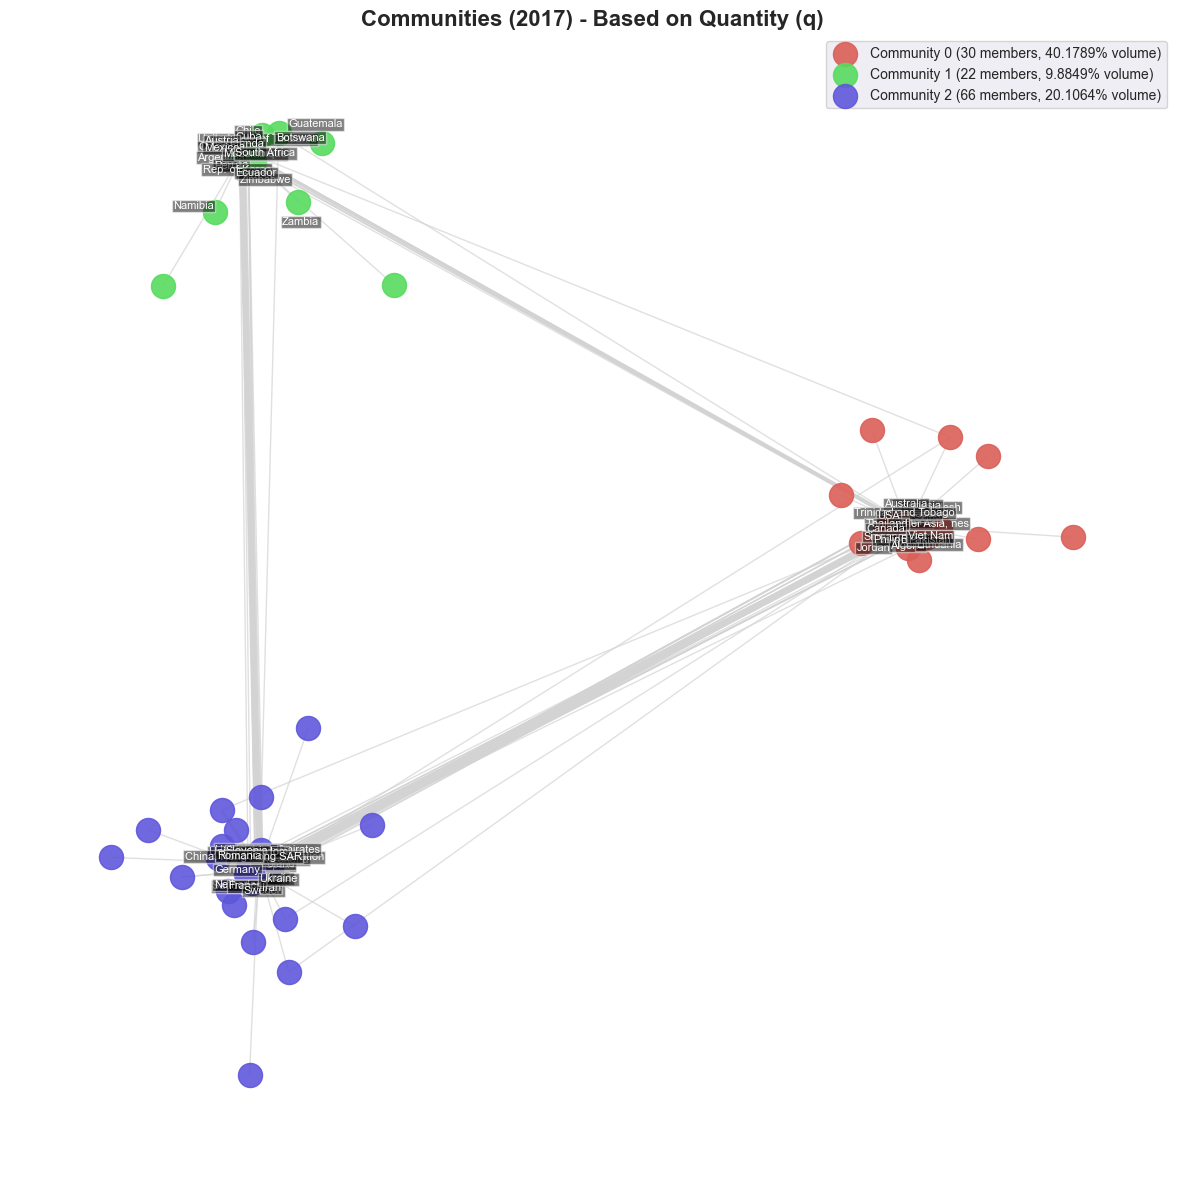

Top Countries by Community based on q for year 1.8200323271166483:
Community 0:
  China | Japan | USA | Canada | Thailand | Singapore | Other Asia, nes | Indonesia | Australia | Algeria | Philippines | Viet Nam | Pakistan | Brazil | Bangladesh | Trinidad and Tobago | Ireland | Lithuania | Venezuela | Jordan
Community 1:
  Rep. of Korea | Chile | South Africa | Mexico | Argentina | Austria | Peru | Colombia | Cuba | United Rep. of Tanzania | Kenya | Ecuador | Nigeria | Uganda | Zimbabwe | Mozambique | Botswana | Namibia | Zambia | Guatemala
Community 2:
  Belgium | Russian Federation | Germany | Netherlands | India | France | United Kingdom | Türkiye | Spain | Slovenia | United Arab Emirates | Sweden | Poland | Iran | China, Hong Kong SAR | Switzerland | Italy | Saudi Arabia | Ukraine | Romania


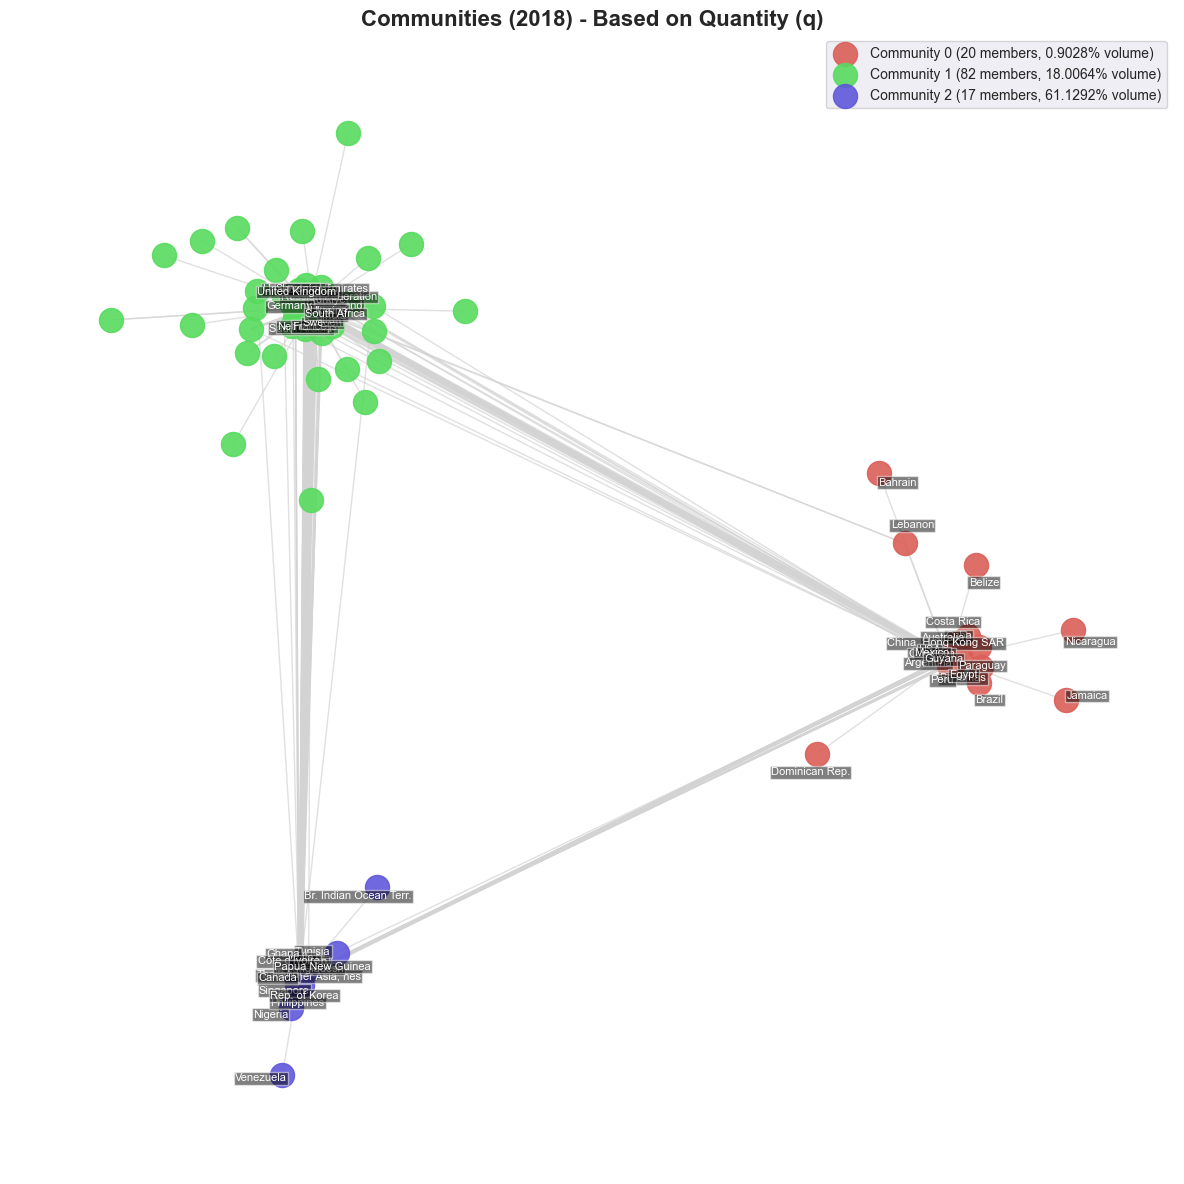

Top Countries by Community based on q for year 1.723601396945711:
Community 0:
  USA | Argentina | Egypt | Mexico | Australia | Colombia | China, Hong Kong SAR | Peru | Cuba | Guyana | Costa Rica | Paraguay | Bahamas | Brazil | Belize | Jamaica | Nicaragua | Lebanon | Dominican Rep. | Bahrain
Community 1:
  Russian Federation | Belgium | Germany | Netherlands | India | France | United Kingdom | Türkiye | United Arab Emirates | Spain | Sweden | Slovenia | South Africa | Switzerland | Indonesia | Poland | Saudi Arabia | Iran | Italy | Ukraine
Community 2:
  China | Japan | Rep. of Korea | Chile | Canada | Singapore | Thailand | Other Asia, nes | Philippines | Bangladesh | Tunisia | Ghana | Côte d'Ivoire | Nigeria | Papua New Guinea | Venezuela | Br. Indian Ocean Terr.


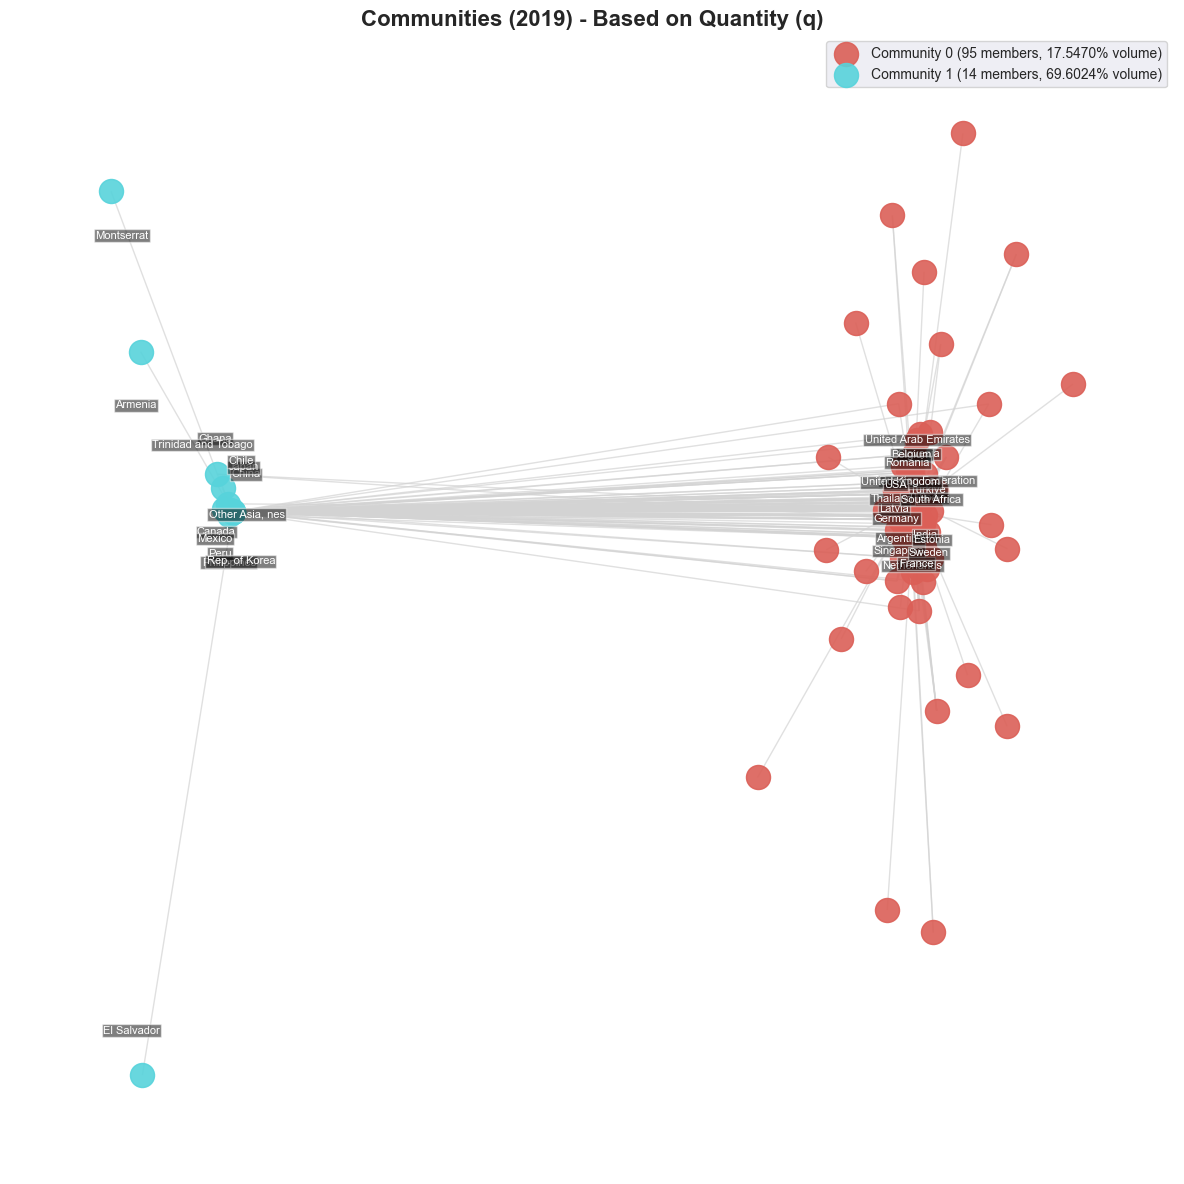

Top Countries by Community based on q for year 0.04141711105771893:
Community 0:
  USA | Belgium | Russian Federation | Germany | Netherlands | India | France | United Kingdom | Türkiye | Singapore | Thailand | Spain | United Arab Emirates | Argentina | Slovenia | Estonia | Sweden | Romania | Latvia | South Africa
Community 1:
  China | Japan | Rep. of Korea | Chile | Canada | Mexico | Other Asia, nes | Peru | Philippines | Ghana | Trinidad and Tobago | Armenia | Montserrat | El Salvador


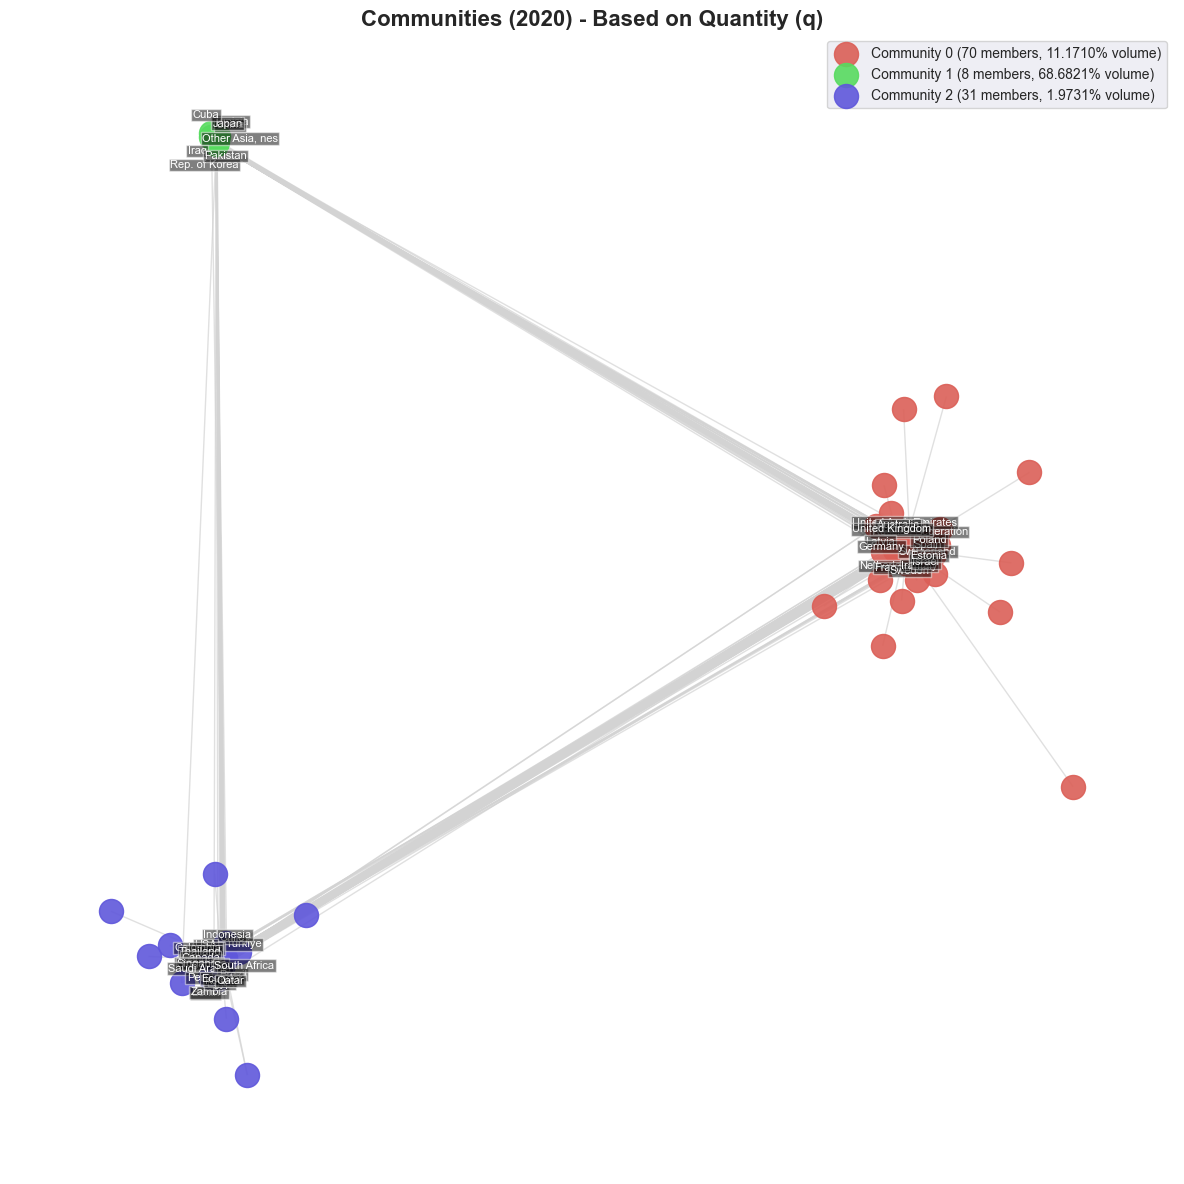

Top Countries by Community based on q for year -1.7387145774955721:
Community 0:
  Russian Federation | Belgium | Netherlands | Germany | India | France | United Kingdom | United Arab Emirates | Spain | Estonia | Sweden | Romania | Switzerland | Iran | Poland | Slovenia | Latvia | Australia | Israel | Italy
Community 1:
  China | Rep. of Korea | Japan | Other Asia, nes | Iraq | Pakistan | Cuba | Tunisia
Community 2:
  USA | Chile | Canada | Thailand | Singapore | Türkiye | Argentina | South Africa | Saudi Arabia | Indonesia | Egypt | Austria | Colombia | Peru | Kenya | Qatar | Benin | Zambia | Ecuador | Brazil


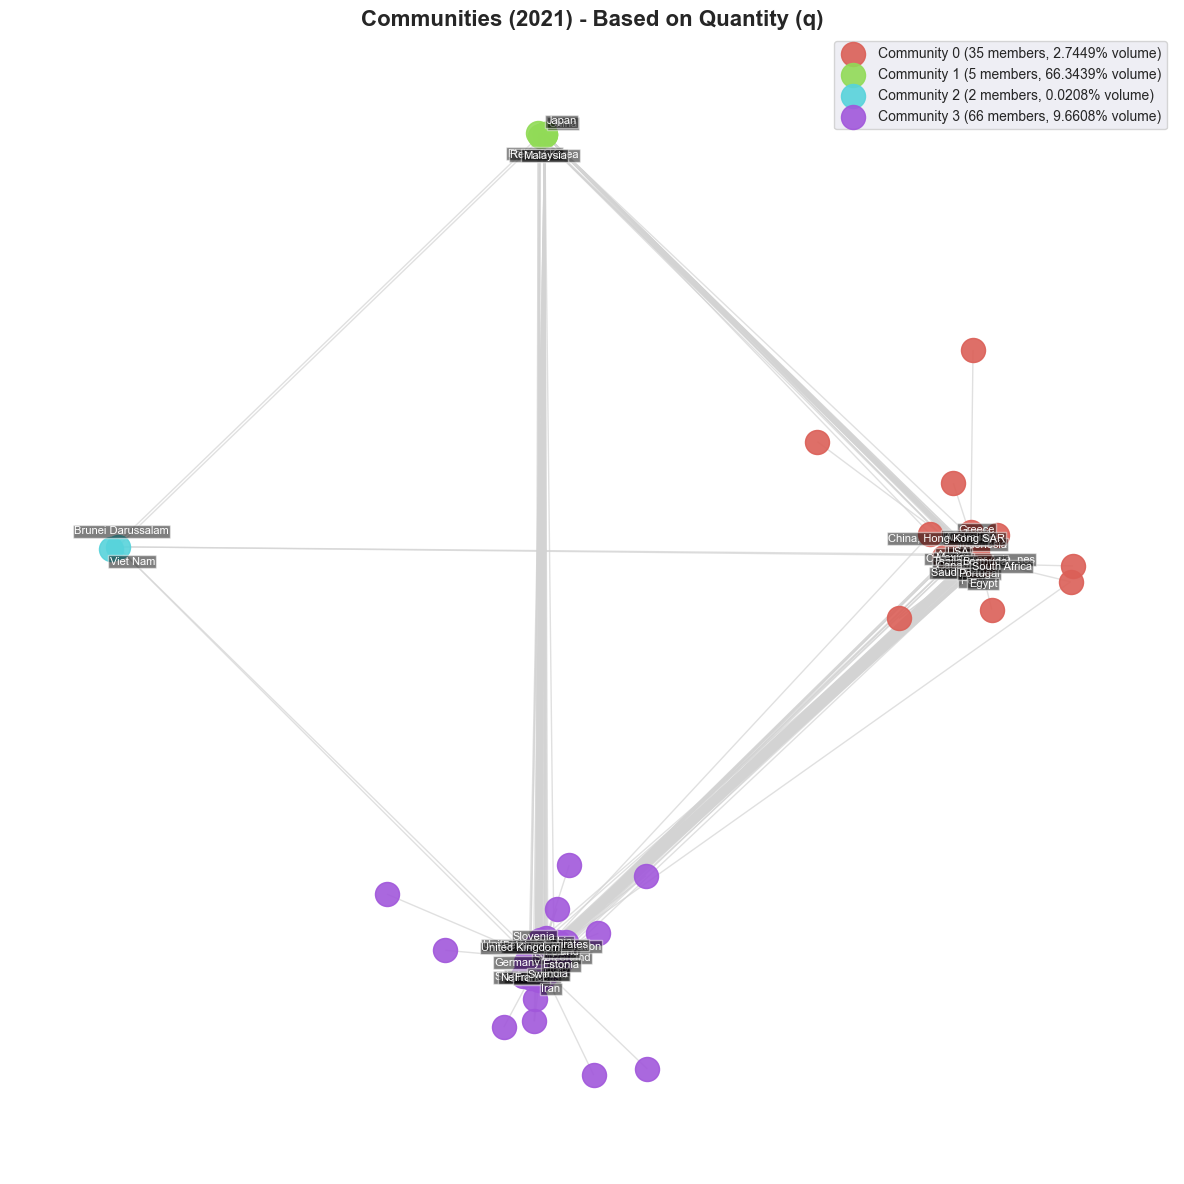

Top Countries by Community based on q for year -0.07584567152686957:
Community 0:
  USA | Chile | Canada | Other Asia, nes | Australia | Thailand | Indonesia | Argentina | South Africa | Saudi Arabia | Mexico | Egypt | Romania | Portugal | Peru | Austria | Colombia | Greece | China, Hong Kong SAR | Bermuda
Community 1:
  China | Rep. of Korea | Japan | Malaysia | Philippines
Community 2:
  Viet Nam | Brunei Darussalam
Community 3:
  Russian Federation | Netherlands | Belgium | Germany | India | France | United Kingdom | United Arab Emirates | Singapore | Türkiye | Estonia | Poland | Spain | Slovenia | Switzerland | Sweden | Latvia | Italy | Czechia | Iran


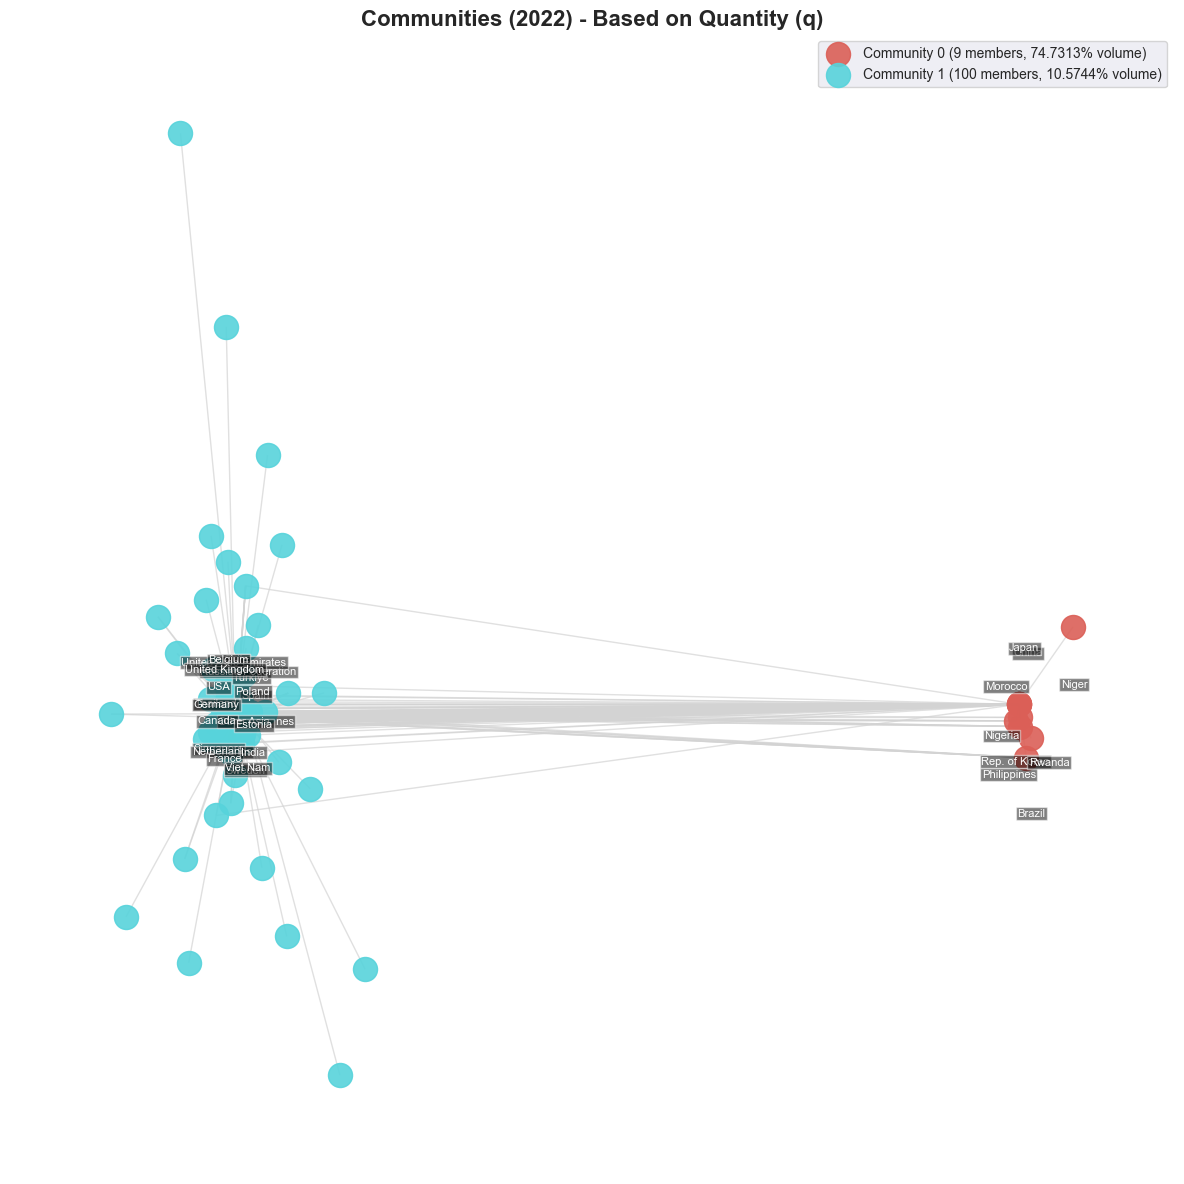

Top Countries by Community based on q for year -0.003121552358151279:
Community 0:
  China | Rep. of Korea | Japan | Nigeria | Philippines | Morocco | Rwanda | Brazil | Niger
Community 1:
  Chile | USA | Russian Federation | Poland | Netherlands | Belgium | United Kingdom | India | Germany | Singapore | United Arab Emirates | Sweden | France | Türkiye | Other Asia, nes | Thailand | Canada | Estonia | Spain | Viet Nam


In [16]:



##############################################
# Community Visualization
##############################################
sns.set_theme(style='darkgrid')

for y in years:
    G = yearly_graphs[y]
    if G.number_of_nodes() == 0:
        print(f"Year {y}: No nodes to plot.")
        continue

    # Community Detection
    if G.number_of_edges() > 0:
        partition = community_louvain.best_partition(G, weight='weight')
    else:
        partition = {n:0 for n in G.nodes()}

    communities = {}
    for n, c in partition.items():
        communities.setdefault(c, []).append(n)

    # Computation of Node Strenght based on the Volume "q"
    node_strengths = {}
    for n in G.nodes():
        strength = sum(d['weight'] for _,_,d in G.edges(n, data=True))
        node_strengths[n] = strength

    # Selection of Top Nodes per Community (Annotation and Summary Stats)
    top_per_community = {}
    top_n_per_comm = 20
    for c, nodes in communities.items():
        nodes_strength = [(n, node_strengths[n]) for n in nodes]
        nodes_strength.sort(key=lambda x:x[1], reverse=True)
        top_nodes_c = [x[0] for x in nodes_strength[:top_n_per_comm]]
        top_per_community[c] = top_nodes_c

    top_nodes = set()
    for c in top_per_community:
        top_nodes.update(top_per_community[c])

    pos = nx.spring_layout(G, seed=42, k=0.15, iterations=100)

    num_com = len(communities)
    radius = 2.0
    angles = np.linspace(0, 2*math.pi, num_com, endpoint=False)
    offsets = [(radius*math.cos(a), radius*math.sin(a)) for a in angles]

    sorted_communities = sorted(communities.keys())
    palette = sns.color_palette("hls", num_com)
    community_colors = {}
    for i, c in enumerate(sorted_communities):
        community_colors[c] = palette[i]

    for i, c in enumerate(sorted_communities):
        nodes = communities[c]
        cx = np.mean([pos[n][0] for n in nodes])
        cy = np.mean([pos[n][1] for n in nodes])
        ox, oy = offsets[i]
        for n in nodes:
            pos[n] = (pos[n][0] - cx + ox, pos[n][1] - cy + oy)

    plt.figure(figsize=(12,12))
    plt.title(f"Communities ({y}) - Based on Quantity (q)", fontsize=16, fontweight='bold')

    nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.7)

    # Computation of Community Shares of the Volume
    total_volume = sum(d['weight'] for _,_,d in G.edges(data=True))
    community_volumes = {}
    for c in sorted_communities:
        com_nodes = set(communities[c])
        com_volume = sum(d['weight'] for (u,v,d) in G.edges(data=True)
                         if u in com_nodes and v in com_nodes)
        community_volumes[c] = com_volume

    handles = []
    labels = []
    for c in sorted_communities:
        nodes = communities[c]
        scatter = nx.draw_networkx_nodes(G, pos, nodelist=nodes,
                                         node_color=[community_colors[c]],
                                         node_size=300, alpha=0.9)
        share = (community_volumes[c] / total_volume)*100 if total_volume > 0 else 0.0
        community_label = f"Community {c} ({len(nodes)} members, {share:.4f}% volume)"
        handles.append(scatter)
        labels.append(community_label)

    label_positions = {}
    top_nodes = list(top_nodes)
    for i, n in enumerate(top_nodes):
        x, y = pos[n]
        angle = 2*math.pi*(i/len(top_nodes))
        offset_dist = 0.10
        dx = offset_dist*math.cos(angle)
        dy = offset_dist*math.sin(angle)
        label_positions[n] = (x+dx, y+dy)

    nx.draw_networkx_labels(G, label_positions,
                            labels={n:n for n in top_nodes},
                            font_size=8, font_color='white',
                            bbox=dict(facecolor='black', alpha=0.5, pad=1))

    plt.axis('off')
    plt.legend(handles, labels, fontsize=10, loc='upper right', frameon=True)
    plt.tight_layout()
    plt.show()

    print(f"Top Countries by Community based on q for year {y}:")
    for c in sorted_communities:
        print(f"Community {c}:\n  {' | '.join(top_per_community[c])}")
